In [1]:
import os
import pandas
import numpy as np
import torch
import matplotlib.pyplot as plt
import hcpdatautils as hcp
import isingutils as ising

In [2]:
int_type = torch.int
float_type = torch.float
device = torch.device('cuda')

In [3]:
data_dir = 'E:\\HCP_data'
model_dir = 'E:\\Ising_model_results_daai'
stats_dir = 'E:\\Ising_model_results_daai'

In [4]:
with torch.no_grad():
    subject_ids = hcp.load_training_subjects(data_dir)
    data_ts = ising.standardize_and_binarize_ts_data( hcp.load_all_time_series_for_subjects(directory_path=data_dir, subject_ids=subject_ids, dtype=float_type, device=device) ).flatten(start_dim=0, end_dim=2)
    print( data_ts.size() )

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.31 GiB (GPU 0; 8.00 GiB total capacity; 4.32 GiB already allocated; 2.66 GiB free; 4.33 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [4]:
# Take a batch of time series, and output one Fisher information matrix
# slow version that uses less GPU memory.
def get_fisher_info_matrix(ts:torch.Tensor):
    print( 'ts batch size:', ts.size() )
    num_time_points, num_nodes = ts.size()
    ut_indices = torch.triu_indices(row=num_nodes, col=num_nodes, offset=1, device=device)
    ut_rows = ut_indices[0]
    ut_cols = ut_indices[1]
    tsbyts = ts[:,ut_rows] * ts[:,ut_cols]
    ts_params = torch.cat( (ts, tsbyts), dim=1 )
    return torch.cov(ts_params)

In [ ]:
fim = get_fisher_info_matrix(data_ts)

In [4]:
fim_diag = torch.load( os.path.join(model_dir, 'training_data_fim_diag.pt') )
print( fim_diag.size() )

torch.Size([64980])


In [5]:
num_nodes = 360
num_pairs = ( num_nodes * (num_nodes-1) )//2
num_vars = num_nodes + num_pairs
print(f'num nodes {num_nodes} + num pairs {num_pairs} = num vars {num_vars}')
fim_diag_h = fim_diag[:num_nodes]
fim_diag_J = fim_diag[num_nodes:]

num nodes 360 + num pairs 64620 = num vars 64980


In [7]:
def print_stats(name:str, values:torch.Tensor):
    values = values.flatten()
    quantile_cutoffs = torch.tensor([0.025, 0.5, 0.975], dtype=float_type, device=device)
    quantiles = torch.quantile(values, quantile_cutoffs)
    min_val = torch.min(values)
    max_val = torch.max(values)
    print(f'The distribution of {name} values has median {quantiles[1].item():.3g} with 95% CI [{quantiles[0].item():.3g}, {quantiles[2].item():.3g}] and range [{min_val.item():.3g}, {max_val.item():.3g}].')

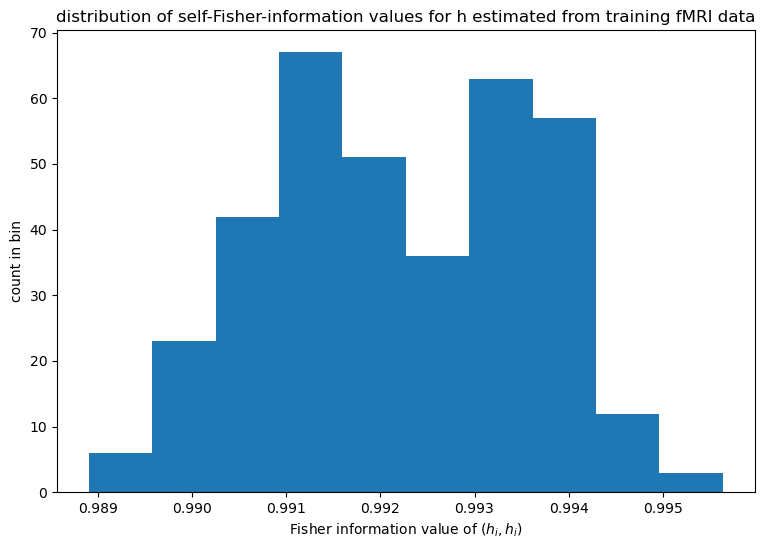

The distribution of h self-Fisher-information values has median 0.992 with 95% CI [0.99, 0.995] and range [0.989, 0.996].


In [13]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.hist( fim_diag_h.detach().cpu().numpy() )
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs.set_xlabel('Fisher information value of $(h_i,h_i)$')
axs.set_ylabel('count in bin')
axs.set_title('distribution of self-Fisher-information values for h estimated from training fMRI data')
plt.show()
print_stats('h self-Fisher-information', fim_diag_h)

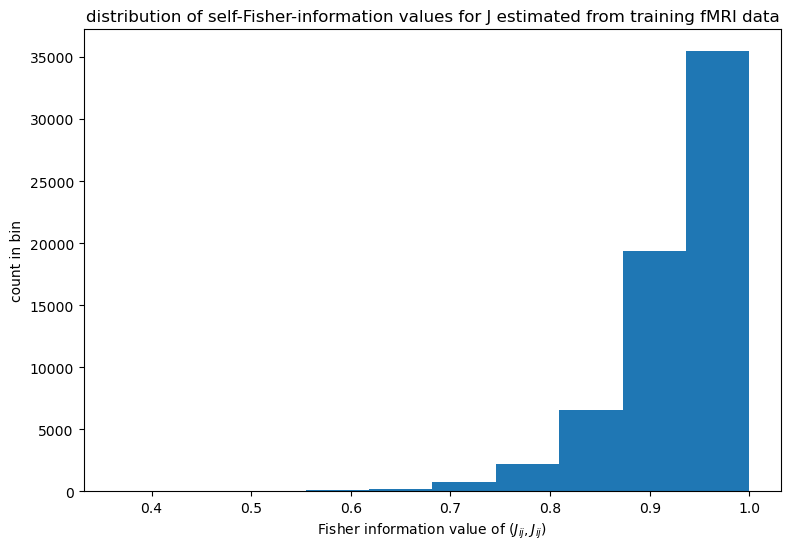

The distribution of J self-Fisher-information values has median 0.942 with 95% CI [0.767, 0.989] and range [0.364, 1].


In [14]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.hist( fim_diag_J.detach().cpu().numpy() )
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs.set_xlabel('Fisher information value of $(J_{ij},J_{ij})$')
axs.set_ylabel('count in bin')
axs.set_title('distribution of self-Fisher-information values for J estimated from training fMRI data')
plt.show()
print_stats('J self-Fisher-information', fim_diag_J)

In [16]:
fim_h_only = torch.load( os.path.join(model_dir, 'training_data_fim_h_only.pt') )
print( fim_h_only.size() )

torch.Size([360, 360])


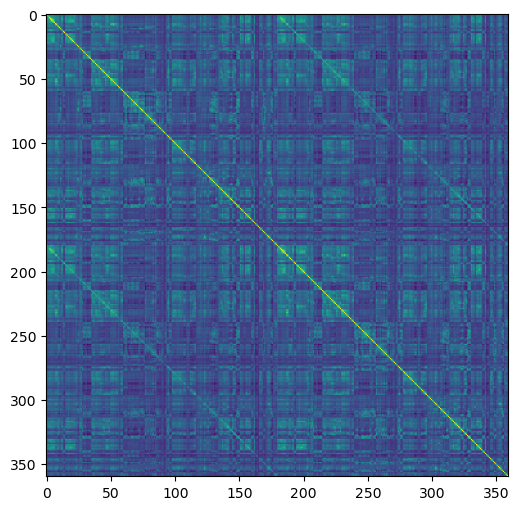

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.imshow( fim_h_only.detach().cpu().numpy() )

In [731]:
print( 837 * 90 )

75330


torch.Size([357, 357])


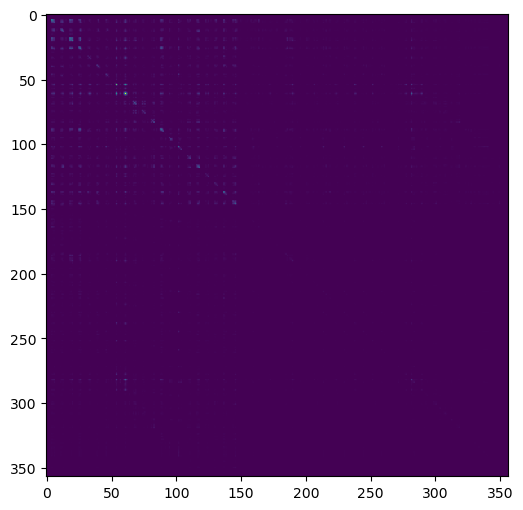

In [5]:
fim_param_string = 'epochs_2000_val_batch_100_steps_4800_lr_0.0001_batches_1000_node_hl_3_node_w_7_edge_hl_3_edge_w_15_ising_nodes_21_reps_100_epochs_1000_window_50_lr_0.001_threshold_0.100_subject_101309_steps_48000'
fim_struct2ising_file = os.path.join(stats_dir, f'fim_struct2ising_struct2ising_{fim_param_string}.pt')
fim_struct2ising = torch.load(fim_struct2ising_file)
print( fim_struct2ising.size() )
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.imshow( fim_struct2ising.abs().detach().cpu().numpy() )

torch.Size([357, 357])


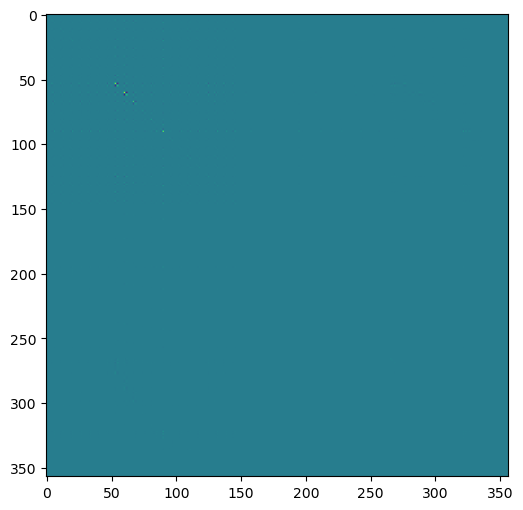

In [647]:
# fim_struct2ising_mean_file = os.path.join(stats_dir, 'fim_struct2ising_struct2ising_epochs_2000_val_batch_100_steps_4800_lr_0.0001_batches_1000_node_hl_3_node_w_7_edge_hl_3_edge_w_15_ising_nodes_21_reps_100_epochs_1000_window_50_lr_0.001_threshold_0.100_mean_steps_48000.pt')
# fim_struct2ising_mean_file = os.path.join(stats_dir, 'fim_struct2ising_struct2ising_epochs_2000_val_batch_100_steps_4800_lr_0.0001_batches_1000_node_hl_3_node_w_7_edge_hl_3_edge_w_15_ising_nodes_21_reps_100_epochs_1000_window_50_lr_0.001_threshold_0.100_validation_mean_steps_48000.pt')
# fim_param_string = 'struct2ising_epochs_2000_val_batch_100_steps_4800_lr_0.0001_batches_1000_node_hl_3_node_w_7_edge_hl_3_edge_w_15_ising_nodes_21_reps_100_epochs_1000_window_50_lr_0.001_threshold_0.100_mean_validation_steps_48000'
fim_param_string = 'struct2ising_epochs_2000_val_batch_100_steps_4800_lr_0.0001_batches_1000_node_hl_3_node_w_7_edge_hl_3_edge_w_15_ising_nodes_21_reps_100_epochs_1000_window_50_lr_0.001_threshold_0.100_mean_training_48000'
fim_struct2ising_mean_file = os.path.join(stats_dir, f'fim_struct2ising_{fim_param_string}.pt')
fim_struct2ising = torch.load(fim_struct2ising_mean_file)
print( fim_struct2ising.size() )
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.imshow( fim_struct2ising.detach().cpu().numpy() )

In [648]:
print_stats(name='structural feature FIM', values=fim_struct2ising)

The distribution of structural feature FIM values has median -3.52e-08 with 95% CI [-0.762, 0.738] and range [-248, 338].


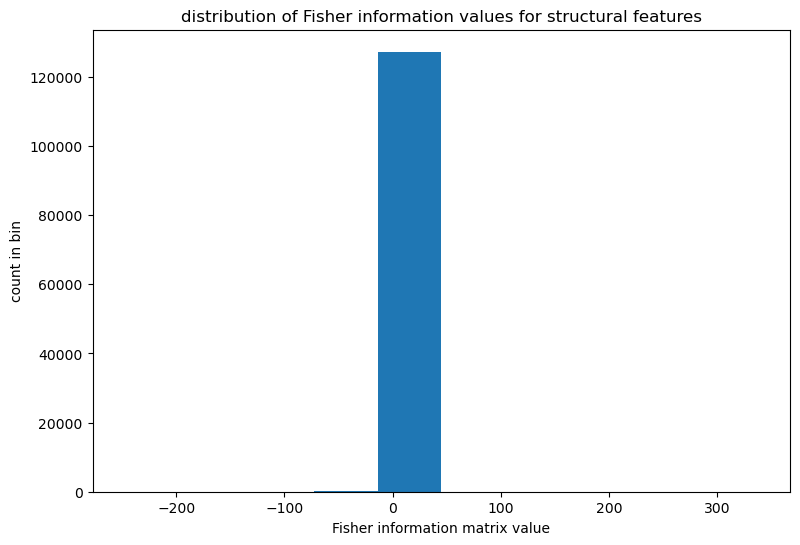

In [649]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.hist( fim_struct2ising.flatten().detach().cpu().numpy() )
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs.set_xlabel('Fisher information matrix value')
axs.set_ylabel('count in bin')
axs.set_title('distribution of Fisher information values for structural features')
plt.show()

torch.Size([462, 462])


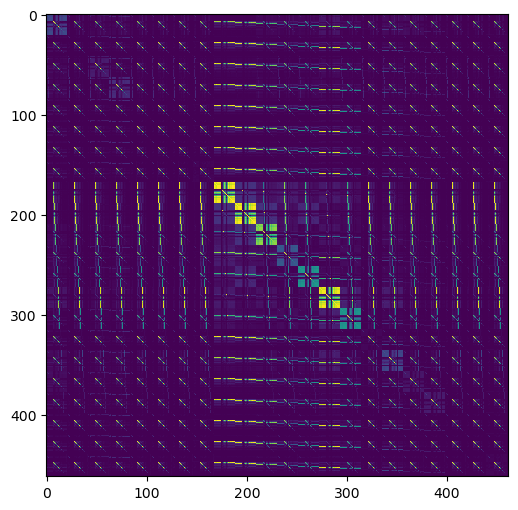

In [650]:
fim_ising_file = os.path.join(stats_dir, f'fim_ising_{fim_param_string}.pt')
fim_ising = torch.load(fim_ising_file)
print( fim_ising.size() )
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.imshow( fim_ising.abs().detach().cpu().numpy() )

The distribution of subject 101309 structure-predicted Ising model FIM values has median 0 with 95% CI [-0.141, 0.288] and range [-0.845, 1].


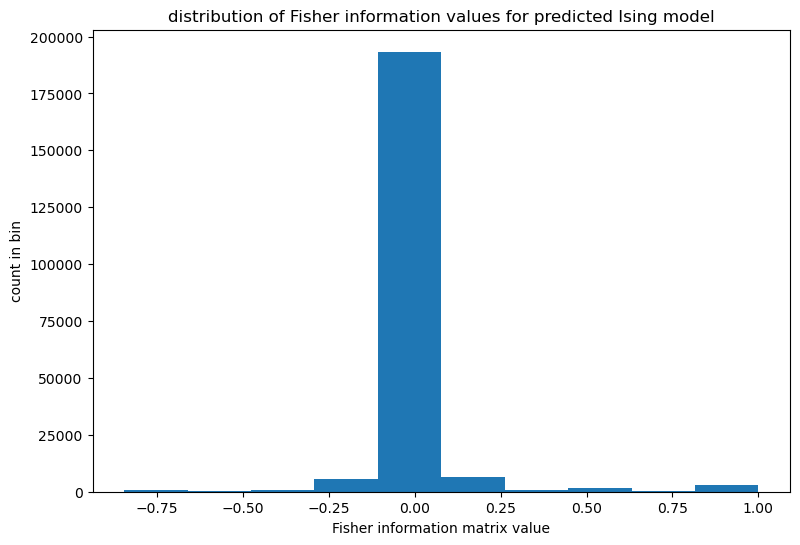

In [651]:
print_stats(name='subject 101309 structure-predicted Ising model FIM', values=fim_ising)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.hist( fim_ising.flatten().detach().cpu().numpy() )
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs.set_xlabel('Fisher information matrix value')
axs.set_ylabel('count in bin')
axs.set_title('distribution of Fisher information values for predicted Ising model')
plt.show()

torch.Size([462, 357])


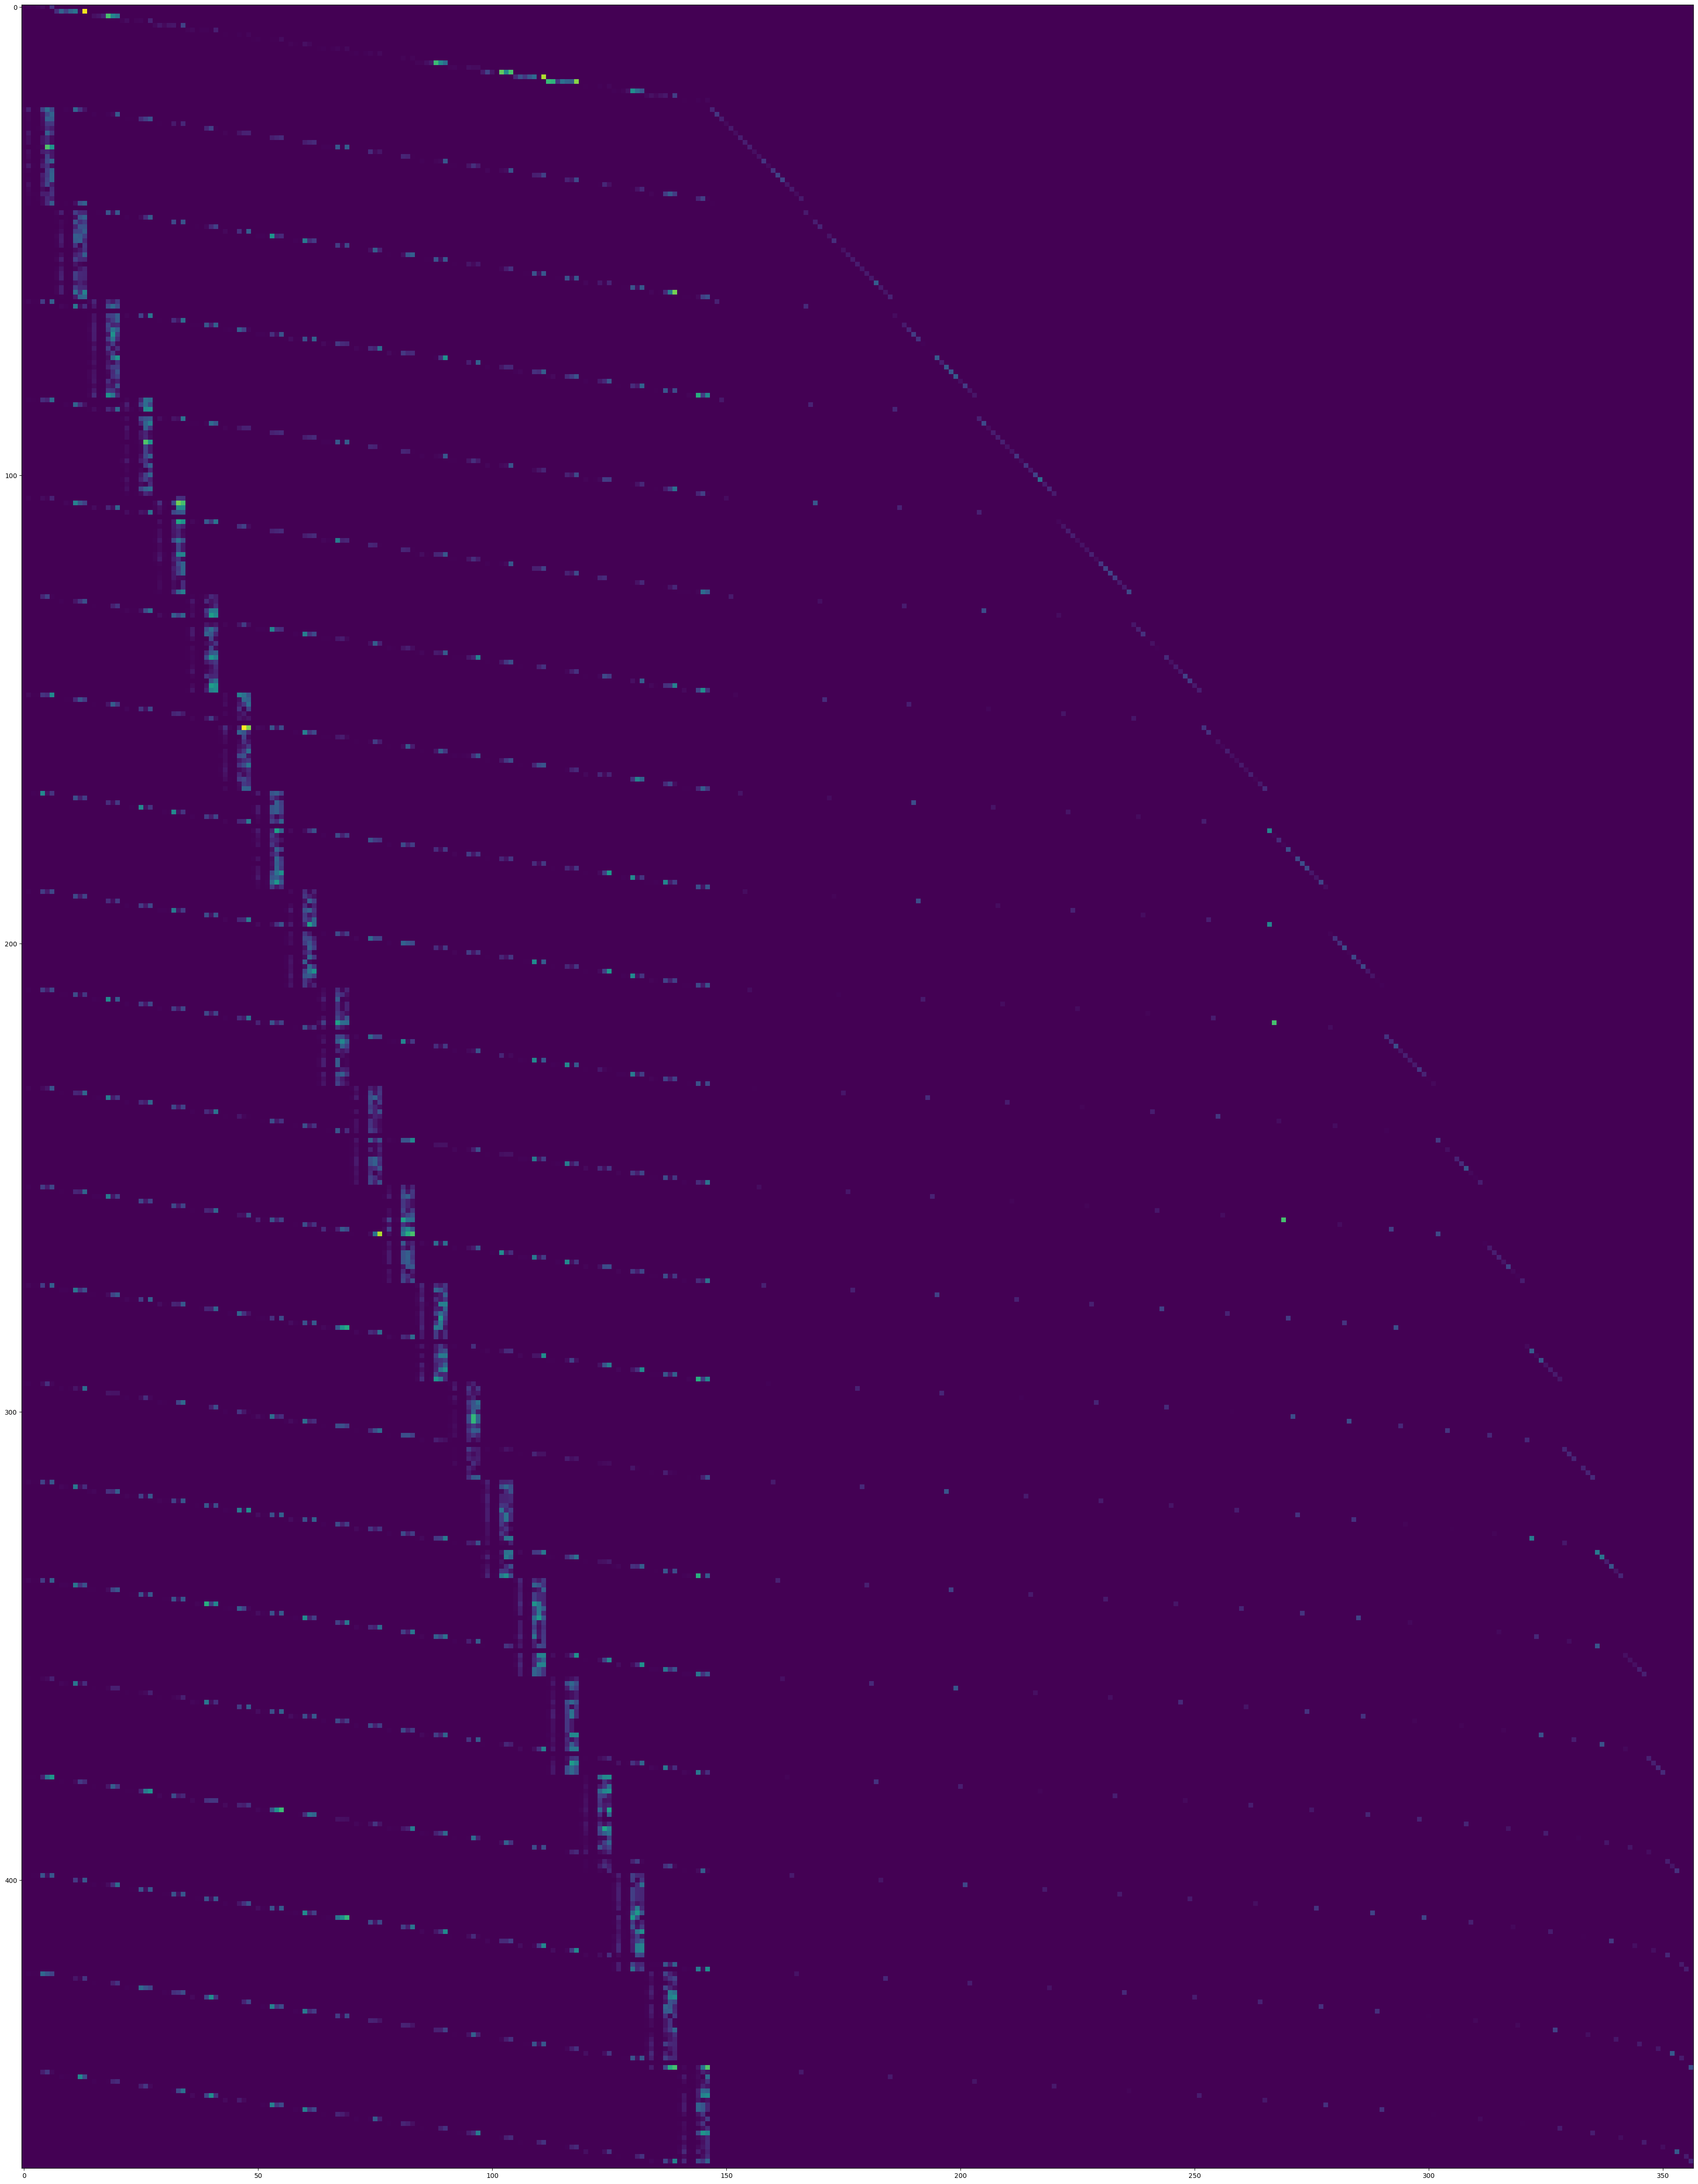

In [652]:
jacobian_file = os.path.join(stats_dir, f'jacobian_{fim_param_string}.pt')
jacobian = torch.load(jacobian_file)
print( jacobian.size() )
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(90, 60))
axs.imshow( jacobian.abs().detach().cpu().numpy() )

The distribution of subject 101309 structure-to-Ising Jacobian values has median 0 with 95% CI [0, 0] and range [-3.5, 3.43].


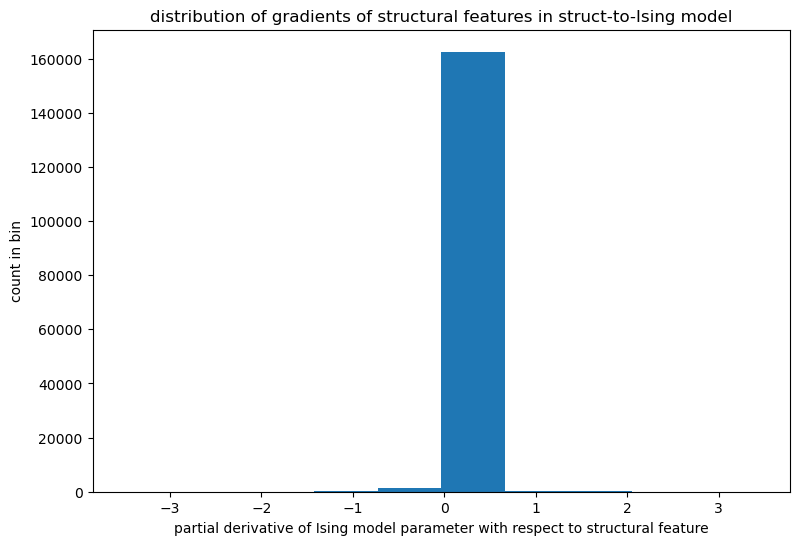

In [653]:
print_stats(name='subject 101309 structure-to-Ising Jacobian', values=jacobian)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.hist( jacobian.flatten().detach().cpu().numpy() )
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs.set_xlabel('partial derivative of Ising model parameter with respect to structural feature')
axs.set_ylabel('count in bin')
axs.set_title('distribution of gradients of structural features in struct-to-Ising model')
plt.show()

In [654]:
print( torch.sum(jacobian != 0, dim=1) )

tensor([ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  0, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15,  0, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,  0, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,  0, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15,  0, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15,  0, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15,  0, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,  0, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,  0,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15,  0, 15, 15, 15, 15, 

In [655]:
with open( os.path.join(stats_dir, 'param_labels_struct2ising_epochs_500_val_batch_100_steps_4800_lr_0.0001_batches_1000_node_hl_2_node_w_21_edge_hl_2_edge_w_441_ising_nodes_21_reps_100_epochs_1000_window_50_lr_0.001_threshold_0.100_steps_48000.txt') ) as param_name_file:
    param_names = param_name_file.read().splitlines()

In [656]:
print( len(param_names) )

357


In [657]:
is_thickness = [param_name.startswith('thickness') for param_name in param_names]
print( 'thicknesses:', sum(is_thickness) )
is_myelination = [param_name.startswith('myelination') for param_name in param_names]
print( 'myelinations:', sum(is_thickness) )
is_curvature = [param_name.startswith('curvature') for param_name in param_names]
print( 'curvatures:', sum(is_curvature) )
is_sulcus_depth = [param_name.startswith('sulcus depth') for param_name in param_names]
print( 'sulcus depths:', sum(is_sulcus_depth) )
is_x = [param_name.startswith('x') for param_name in param_names]
print( 'xs:', sum(is_x) )
is_y = [param_name.startswith('y') for param_name in param_names]
print( 'ys:', sum(is_y) )
is_z = [param_name.startswith('z') for param_name in param_names]
print( 'zs:', sum(is_z) )
is_sc = [param_name.startswith('SC') for param_name in param_names]
print( 'SCs:', sum(is_sc) )

thicknesses: 21
myelinations: 21
curvatures: 21
sulcus depths: 21
xs: 21
ys: 21
zs: 21
SCs: 210


torch.Size([357])
The distribution of thickness FIM values has median 0.00814 with 95% CI [0.0021, 0.682] and range [0.00184, 1.23].
The distribution of myelination FIM values has median 0.484 with 95% CI [0.0748, 5.3] and range [0.0734, 6.2].
The distribution of curvature FIM values has median 0.00938 with 95% CI [0.00133, 0.149] and range [0.00105, 0.161].
The distribution of sulcus depth FIM values has median 0.00315 with 95% CI [0.000696, 0.362] and range [0.000577, 0.375].
The distribution of x FIM values has median 10.7 with 95% CI [3.15, 324] and range [2.84, 338].
The distribution of y FIM values has median 7.13 with 95% CI [2.76, 13.3] and range [2.44, 13.5].
The distribution of z FIM values has median 15.3 with 95% CI [6.35, 249] and range [5.86, 308].
The distribution of SC FIM values has median 0.0356 with 95% CI [4.81e-05, 2.43] and range [9.63e-07, 9.88].


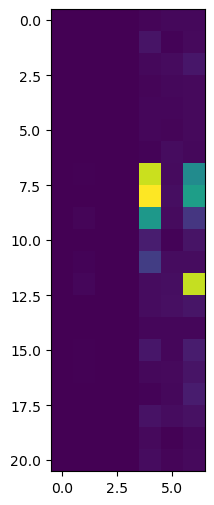

In [658]:
num_nodes = 21
num_region_features = 7
total_region_features = num_nodes * num_region_features
fim_struct2ising_diag = torch.diag(fim_struct2ising)
print( fim_struct2ising_diag.size() )
fim_region_feature_mat = fim_struct2ising_diag[:total_region_features].reshape( (num_nodes,num_region_features) )
fim_sc = fim_struct2ising_diag[total_region_features:]
print_stats(name='thickness FIM', values=fim_region_feature_mat[:,0])
print_stats(name='myelination FIM', values=fim_region_feature_mat[:,1])
print_stats(name='curvature FIM', values=fim_region_feature_mat[:,2])
print_stats(name='sulcus depth FIM', values=fim_region_feature_mat[:,3])
print_stats(name='x FIM', values=fim_region_feature_mat[:,4])
print_stats(name='y FIM', values=fim_region_feature_mat[:,5])
print_stats(name='z FIM', values=fim_region_feature_mat[:,6])
print_stats(name='SC FIM', values=fim_sc)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.imshow( fim_region_feature_mat.abs().detach().cpu().numpy() )

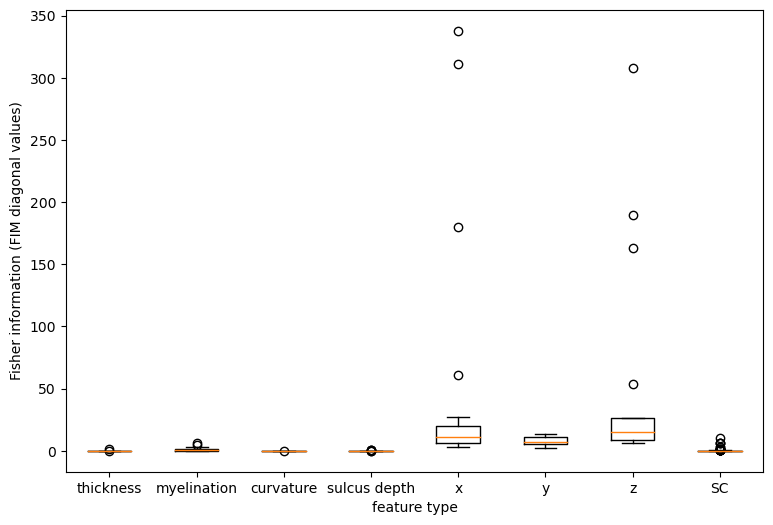

In [659]:
fim_feature_list = fim_region_feature_mat.transpose(dim0=0, dim1=1).tolist()
fim_sc_list = fim_sc.tolist()
fim_feature_list.append(fim_sc_list)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.boxplot( fim_feature_list )
axs.set_xticklabels(['thickness', 'myelination', 'curvature', 'sulcus depth', 'x', 'y', 'z', 'SC'], rotation=0, fontsize=10)
axs.set_xlabel('feature type')
axs.set_ylabel('Fisher information (FIM diagonal values)')
plt.show()

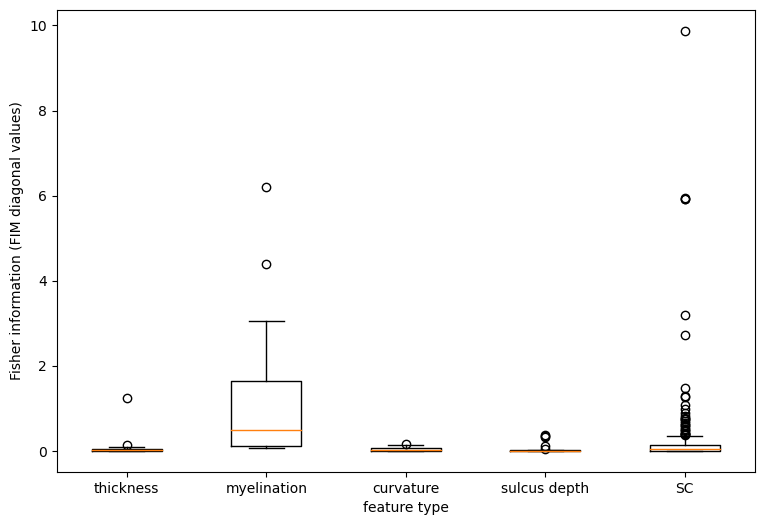

In [660]:
fim_feature_list_no_xyz = fim_region_feature_mat[:,0:4].transpose(dim0=0, dim1=1).tolist()
fim_sc_list = fim_sc.tolist()
fim_feature_list_no_xyz.append(fim_sc_list)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.boxplot( fim_feature_list_no_xyz )
axs.set_xticklabels(['thickness', 'myelination', 'curvature', 'sulcus depth', 'SC'], rotation=0, fontsize=10)
axs.set_xlabel('feature type')
axs.set_ylabel('Fisher information (FIM diagonal values)')
plt.show()

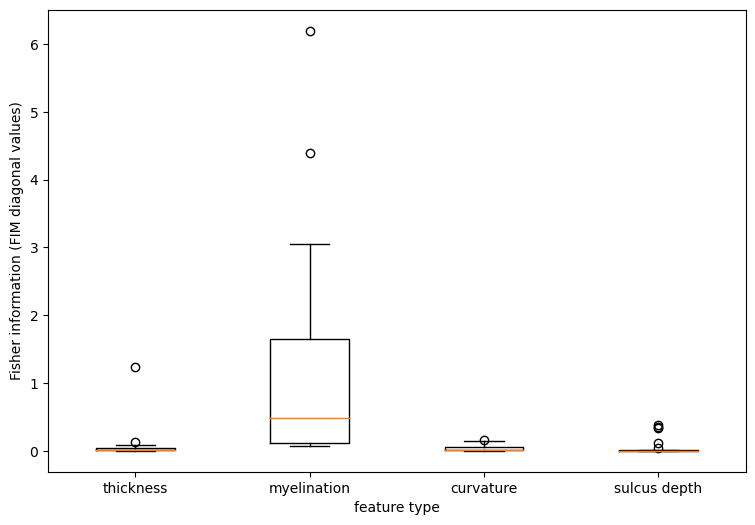

In [661]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.boxplot( fim_feature_list_no_xyz[0:4] )
axs.set_xticklabels(['thickness', 'myelination', 'curvature', 'sulcus depth'], rotation=0, fontsize=10)
axs.set_xlabel('feature type')
axs.set_ylabel('Fisher information (FIM diagonal values)')
plt.show()

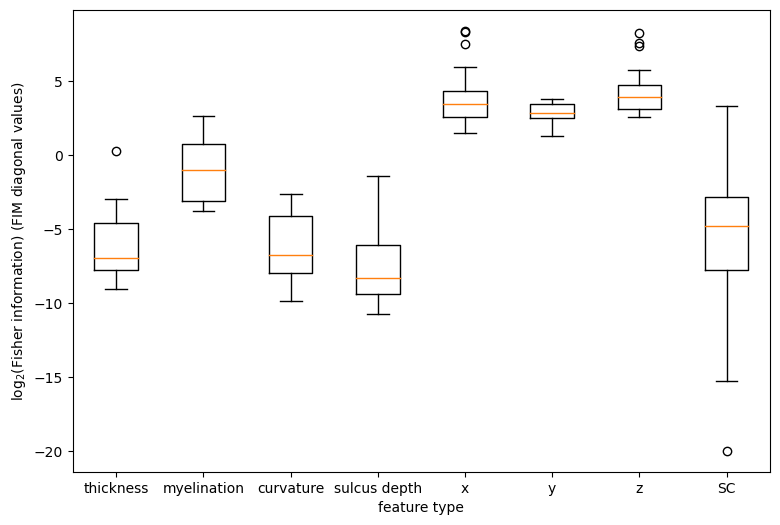

In [662]:
log_fim_feature_list = torch.log2(fim_region_feature_mat).transpose(dim0=0, dim1=1).tolist()
log_fim_sc_list = torch.log2(fim_sc).tolist()
log_fim_feature_list.append(log_fim_sc_list)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.boxplot( log_fim_feature_list )
axs.set_xticklabels(['thickness', 'myelination', 'curvature', 'sulcus depth', 'x', 'y', 'z', 'SC'], rotation=0, fontsize=10)
axs.set_xlabel('feature type')
axs.set_ylabel('log$_2$(Fisher information) (FIM diagonal values)')
plt.show()

In [663]:
data_directory = data_dir
validation_subject_list = hcp.get_has_sc_subject_list( directory_path=data_dir, subject_list=hcp.load_validation_subjects(data_directory) )
training_subject_list = hcp.get_has_sc_subject_list( directory_path=data_dir, subject_list=hcp.load_training_subjects(data_directory) )

In [664]:
node_names, node_coords = hcp.load_roi_info(directory_path=data_directory, dtype=float_type, device=device)

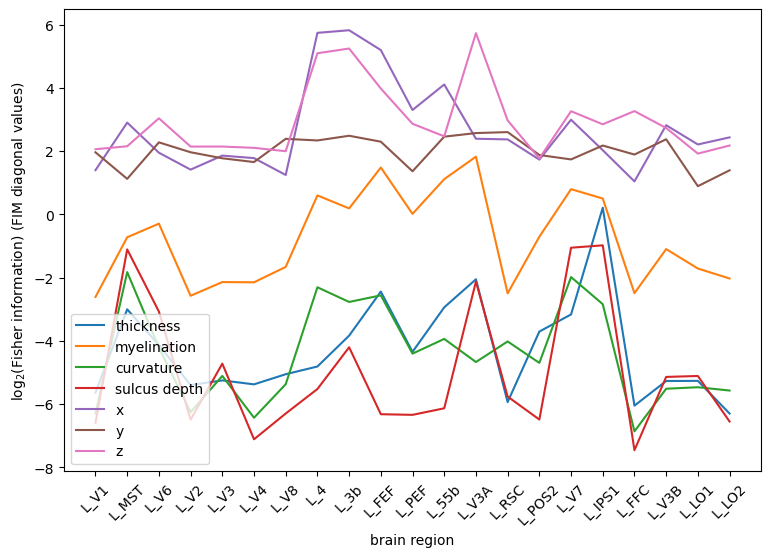

In [665]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.plot( torch.log(fim_region_feature_mat).detach().cpu().numpy(), label=['thickness', 'myelination', 'curvature', 'sulcus depth', 'x', 'y', 'z'] )
axs.set_xticks( range(num_nodes), labels=node_names[:num_nodes], rotation=45, fontsize=10 )
plt.legend()
axs.set_xlabel('brain region')
axs.set_ylabel('log$_2$(Fisher information) (FIM diagonal values)')
plt.show()

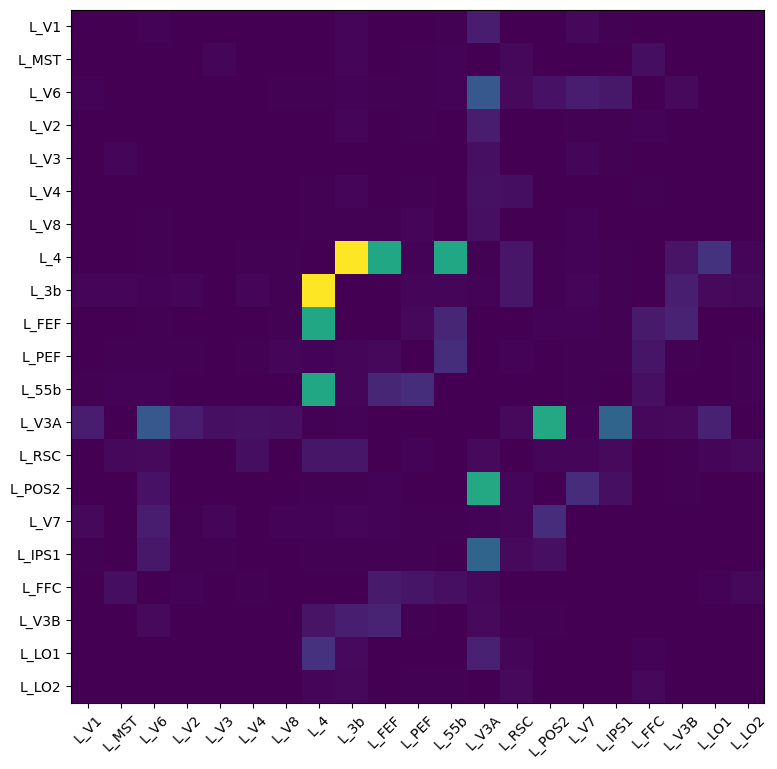

In [666]:
fim_sc_square = torch.zeros( (num_nodes, num_nodes), dtype=float_type, device=device )
sc_indices = torch.triu_indices( row=num_nodes, col=num_nodes, offset=1, device=device )
num_sc_indices = sc_indices.size(dim=1)
for sc_index in range(num_sc_indices):
    sc_r = sc_indices[0,sc_index]
    sc_c = sc_indices[1,sc_index]
    sc_val = fim_sc[sc_index]
    fim_sc_square[sc_r, sc_c] = sc_val
    fim_sc_square[sc_c, sc_r] = sc_val
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 9))
axs.imshow( fim_sc_square.detach().cpu().numpy() )
axs.set_xticks( range(num_nodes), labels=node_names[:num_nodes].tolist(), rotation=45, fontsize=10 )
axs.set_yticks( range(num_nodes), labels=node_names[:num_nodes].tolist(), rotation=0, fontsize=10 )

In [723]:
source_label = [  node_names[ sc_indices[0,i] ] for i in range(num_sc_indices)  ]
target_label = [  node_names[ sc_indices[1,i] ] for i in range(num_sc_indices)  ]
sc_diag_fim = fim_sc.tolist()
sc_fim_table = pandas.DataFrame({'region 1': source_label, 'region 2':target_label, 'Fisher information': sc_diag_fim})
sc_fim_table_sorted = sc_fim_table.sort_values(by='Fisher information', ascending=False)
print(sc_fim_table_sorted)
sc_fim_table_sorted.to_csv( os.path.join(stats_dir, 'sc_fim_table_21_nodes_validation_mean.csv') )

    region 1 region 2  Fisher information
119      L_4     L_3b        9.876769e+00
175    L_V3A   L_POS2        5.947093e+00
122      L_4    L_55b        5.924579e+00
120      L_4    L_FEF        5.916283e+00
177    L_V3A   L_IPS1        3.186936e+00
..       ...      ...                 ...
74      L_V3     L_V4        2.961335e-05
128      L_4    L_FFC        2.883351e-05
88      L_V3    L_LO1        2.762439e-05
27     L_MST    L_FEF        2.582342e-05
103     L_V4    L_LO1        9.629798e-07

[210 rows x 3 columns]


In [668]:
fim_region_feature_list = fim_region_feature_mat.transpose(dim0=0, dim1=1).tolist()
sc_fim_sum = fim_sc_square.sum(dim=0)
fim_region_feature_list.append( sc_fim_sum.tolist() )
region_feature_fim_table = pandas.DataFrame({
    'region': node_names[:num_nodes],
    'thickness': fim_region_feature_list[0],
    'myelination': fim_region_feature_list[1],
    'curvature': fim_region_feature_list[2],
    'sulcus depth': fim_region_feature_list[3],
    'x': fim_region_feature_list[4],
    'y': fim_region_feature_list[5],
    'z': fim_region_feature_list[6],
    'SC sum': fim_region_feature_list[7],
})
print(region_feature_fim_table)
region_feature_fim_table.to_csv( os.path.join(stats_dir, 'region_feature_fim_table_21_nodes_validation_mean.csv') )

    region  thickness  myelination  curvature  sulcus depth           x  \
0     L_V1   0.003562     0.073418   0.001848      0.001374    4.043982   
1    L_MST   0.049662     0.484398   0.160980      0.330503   18.204115   
2     L_V6   0.016062     0.745001   0.014847      0.046286    7.028278   
3     L_V2   0.004520     0.076210   0.001919      0.001517    4.114683   
4     L_V3   0.005246     0.117558   0.006044      0.008909    6.409304   
5     L_V4   0.004628     0.116631   0.001611      0.000815    5.922265   
6     L_V8   0.006377     0.189866   0.004647      0.001841    3.473043   
7      L_4   0.008139     1.821189   0.099725      0.003995  311.001740   
8     L_3b   0.021598     1.206965   0.062678      0.014953  337.860382   
9    L_FEF   0.086956     4.398588   0.077191      0.001800  180.294601   
10   L_PEF   0.012937     1.016018   0.012233      0.001765   27.128807   
11   L_55b   0.052874     3.044153   0.019473      0.002171   60.742531   
12   L_V3A   0.128358    

              thickness  myelination  curvature  sulcus depth         x  \
thickness      1.000000     0.180344   0.156850      0.613464 -0.084908   
myelination    0.180344     1.000000   0.255161      0.215765  0.275923   
curvature      0.156850     0.255161   1.000000      0.702160  0.408683   
sulcus depth   0.613464     0.215765   0.702160      1.000000 -0.162246   
x             -0.084908     0.275923   0.408683     -0.162246  1.000000   
y              0.093450     0.455720  -0.092784     -0.169895  0.367083   
z             -0.006482     0.688004   0.145846      0.015384  0.539066   
SC sum         0.025356     0.613068   0.270692     -0.078740  0.742917   

                     y         z    SC sum  
thickness     0.093450 -0.006482  0.025356  
myelination   0.455720  0.688004  0.613068  
curvature    -0.092784  0.145846  0.270692  
sulcus depth -0.169895  0.015384 -0.078740  
x             0.367083  0.539066  0.742917  
y             1.000000  0.517210  0.529913  
z        

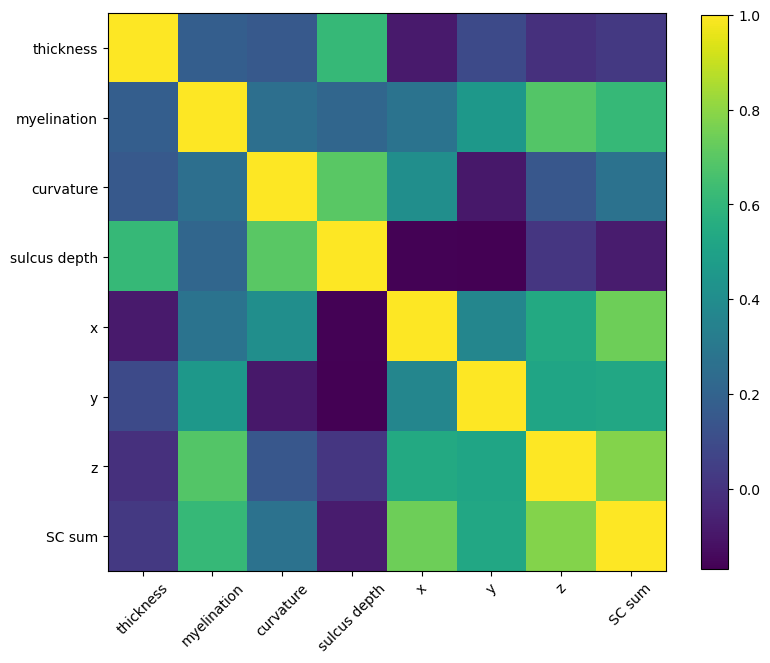

In [669]:
fim_region_feature_mat_with_sc_sum = torch.cat( (fim_region_feature_mat, sc_fim_sum[:,None]), dim=1 )
fim_region_feature_mat_corr = torch.corrcoef( fim_region_feature_mat_with_sc_sum.transpose(dim0=0, dim1=1) )
feature_names_with_sc_sum = ['thickness', 'myelination', 'curvature', 'sulcus depth', 'x', 'y', 'z', 'SC sum']

fim_region_feature_mat_corr_np = fim_region_feature_mat_corr.cpu().numpy()

fim_region_feature_corr_table = pandas.DataFrame( fim_region_feature_mat_corr_np, columns=feature_names_with_sc_sum, index=feature_names_with_sc_sum )
print(fim_region_feature_corr_table)
fim_region_feature_corr_table.to_csv( os.path.join(stats_dir, 'region_feature_fim_table_correlation_21_nodes_validation_mean.csv') )

num_region_features_with_sc_sum = len(feature_names_with_sc_sum)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 9))
pos = axs.imshow(fim_region_feature_mat_corr_np)
axs.set_xticks( range(num_region_features_with_sc_sum), labels=feature_names_with_sc_sum, rotation=45, fontsize=10 )
axs.set_yticks( range(num_region_features_with_sc_sum), labels=feature_names_with_sc_sum, rotation=0, fontsize=10 )
fig.colorbar(pos, ax=axs, shrink=0.8)

In [670]:
def get_structural_data_std_mean(subject_list:list, num_nodes:int, coords:torch.Tensor, dtype=float_type, device=device):
    num_subjects = len(subject_list)
    # Pre-allocate space for the data.
    node_features = torch.zeros( (num_subjects, num_nodes, hcp.features_per_area), dtype=dtype, device=device )
    sc = torch.zeros( (num_subjects, num_nodes, num_nodes), dtype=dtype, device=device )
    # Load all the data from the individual files.
    for subject_index in range(num_subjects):
        subject_id = subject_list[subject_index]
        features_file = hcp.get_area_features_file_path(directory_path=data_directory, subject_id=subject_id)
        node_features[subject_index,:,:] = hcp.load_matrix_from_binary(file_path=features_file, dtype=dtype, device=device).transpose(dim0=0, dim1=1)[:num_nodes,:]
        sc_file = hcp.get_structural_connectivity_file_path(directory_path=data_directory, subject_id=subject_id)
        sc[subject_index,:,:] = hcp.load_matrix_from_binary(file_path=sc_file, dtype=dtype, device=device)[:num_nodes,:num_nodes]
    print('loaded data from files' )
    coords_std, coords_mean = torch.std_mean(coords, dim=0, keepdim=False)# mean over regions
    coords = (coords - coords_mean)/coords_std
    node_std, node_mean = torch.std_mean( node_features, dim=(0,1), keepdim=False )# mean over subjects and regions
    node_features = (node_features - node_mean)/node_std
    sc_std, sc_mean = torch.std_mean(sc, keepdim=False)# mean over subjects and region pairs
    sc = (sc - sc_mean)/sc_std
    return coords_std, coords_mean, node_std, node_mean, sc_std, sc_mean

In [671]:
coords_std, coords_mean, node_std, node_mean, sc_std, sc_mean = get_structural_data_std_mean(subject_list=training_subject_list, num_nodes=num_nodes, coords=node_coords, dtype=float_type, device=device)
print( coords_mean, coords_std )

loaded data from files
tensor([  0.2825, -19.0343,  15.7554], device='cuda:0') tensor([36.0952, 40.3998, 26.4462], device='cuda:0')


In [672]:
def get_structural_data(subject_list:list, num_nodes:int, coords:torch.Tensor, dtype=float_type, device=device):
    num_subjects = len(subject_list)
    # Pre-allocate space for the data.
    node_features = torch.zeros( (num_subjects, num_nodes, hcp.features_per_area), dtype=dtype, device=device )
    sc = torch.zeros( (num_subjects, num_nodes, num_nodes), dtype=dtype, device=device )
    # Load all the data from the individual files.
    for subject_index in range(num_subjects):
        subject_id = subject_list[subject_index]
        features_file = hcp.get_area_features_file_path(directory_path=data_directory, subject_id=subject_id)
        node_features[subject_index,:,:] = hcp.load_matrix_from_binary(file_path=features_file, dtype=dtype, device=device).transpose(dim0=0, dim1=1)[:num_nodes,:]
        sc_file = hcp.get_structural_connectivity_file_path(directory_path=data_directory, subject_id=subject_id)
        sc[subject_index,:,:] = hcp.load_matrix_from_binary(file_path=sc_file, dtype=dtype, device=device)[:num_nodes,:num_nodes]
    print('loaded data from files' )
    return node_features, sc

In [673]:
current_subject_list = validation_subject_list# training_subject_list
node_features, sc = get_structural_data(subject_list=current_subject_list, num_nodes=num_nodes, coords=node_coords, dtype=float_type, device=device)

loaded data from files


In [674]:
node_coords_z = (node_coords[:num_nodes,:] - coords_mean)/coords_std
print( node_coords_z.size() )
node_features_z = (node_features - node_mean)/node_std
print( node_features_z.size() )
sc_z = (sc - sc_mean)/sc_std
print( sc_z.size() )
sc_indices = torch.triu_indices( row=sc_z.size(-2), col=sc_z.size(-1), offset=1, device=device )
sc_z_triu = sc_z[:,sc_indices[0],sc_indices[1]]
num_subjects = len(current_subject_list)
node_features_plus_coords_z = torch.cat(  ( node_features_z, node_coords_z[None,:,:].repeat((num_subjects,1,1)) ), dim=-1  )
node_features_plus_sc_z = torch.cat(  ( torch.flatten(node_features_plus_coords_z, start_dim=1, end_dim=-1), sc_z_triu ), dim=1  )
print( node_features_plus_sc_z.size() )

torch.Size([21, 3])
torch.Size([84, 21, 4])
torch.Size([84, 21, 21])
torch.Size([84, 357])


In [675]:
L_fim, V_fim = torch.linalg.eig(fim_struct2ising)
print( 'L_fim size:', L_fim.size() )
print( 'V_fim size:', V_fim.size() )

L_fim size: torch.Size([357])
V_fim size: torch.Size([357, 357])


In [676]:
feature_name_file = os.path.join( stats_dir, 'param_labels_struct2ising_epochs_500_val_batch_100_steps_4800_lr_0.0001_batches_1000_node_hl_2_node_w_21_edge_hl_2_edge_w_441_ising_nodes_21_reps_100_epochs_1000_window_50_lr_0.001_threshold_0.100.txt' )
with open(feature_name_file, 'r', encoding='utf-8') as feature_name_file:
    feature_name_list = list( feature_name_file.read().split('\n') )
feature_name_list = feature_name_list[:-1]
print( len(feature_name_list) )
# print( feature_name_list[0:10] )
# print( feature_name_list[-10:] )
# feature_name_lengths = subject_list = list( map(len, feature_name_list) )
# print(feature_name_lengths)

357


Text(0.5, 1.0, 'distributions of z-scores of structural MRI features in validation data data')

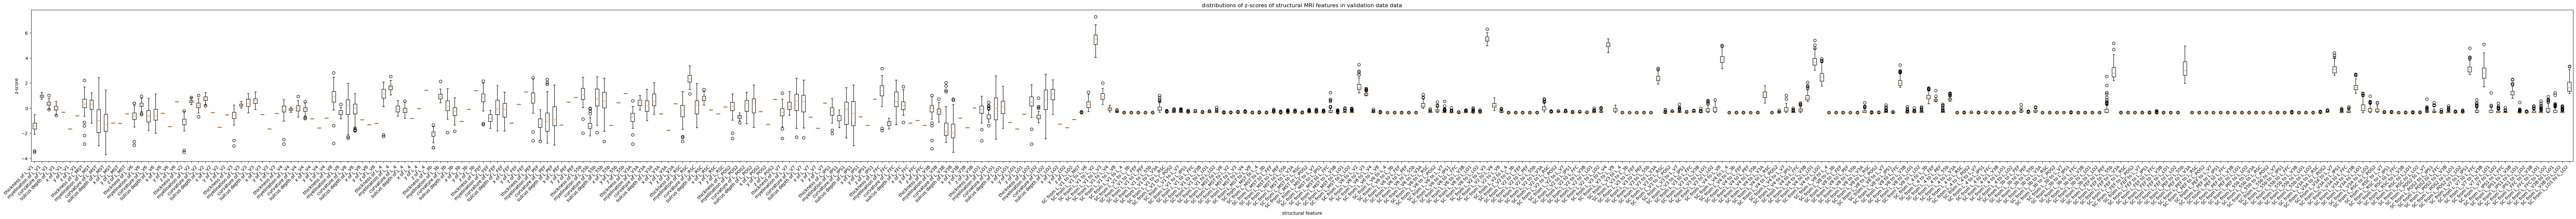

In [677]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(100, 6))
axs.boxplot( node_features_plus_sc_z.detach().cpu().numpy() )
axs.set_xticklabels(feature_name_list, rotation=45, ha='right')
axs.set_xlabel('structural feature')
axs.set_ylabel('z-score')
axs.set_title(f'distributions of z-scores of structural MRI features in validation data data')

Text(0.5, 1.0, 'distributions of z-scores of structural MRI features in validation data data')

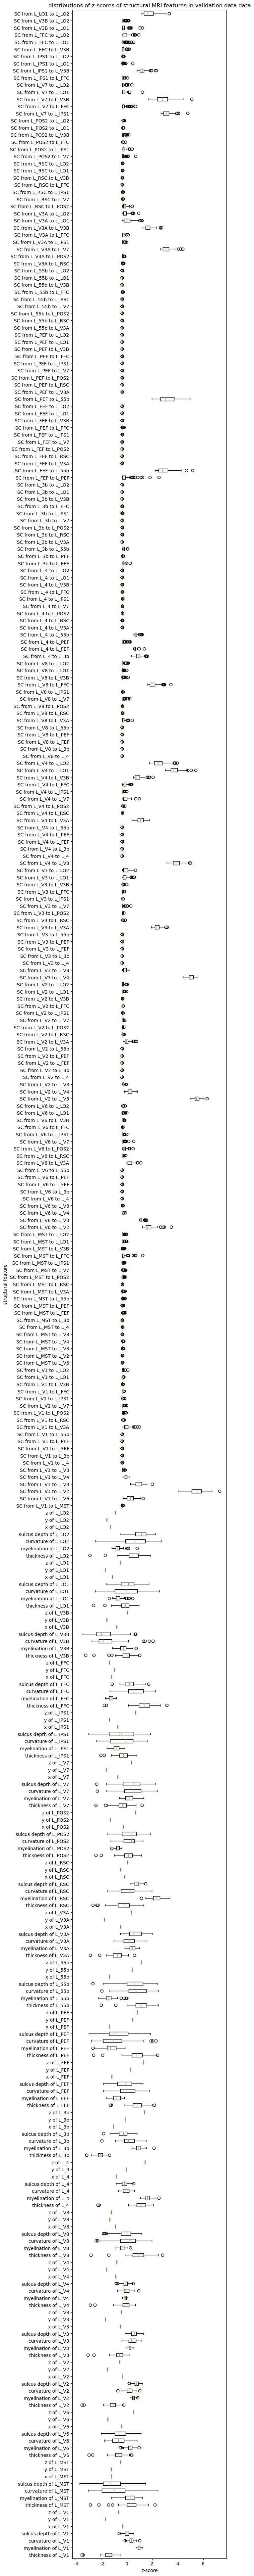

In [678]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 100))
axs.boxplot( node_features_plus_sc_z.detach().cpu().numpy(), vert=False )
axs.set_yticklabels(feature_name_list)
axs.set_ylabel('structural feature')
axs.set_xlabel('z-score')
axs.set_title(f'distributions of z-scores of structural MRI features in validation data data')

Text(0.5, 1.0, 'distributions of z-scores of structural MRI features in validation data data (part 1)')

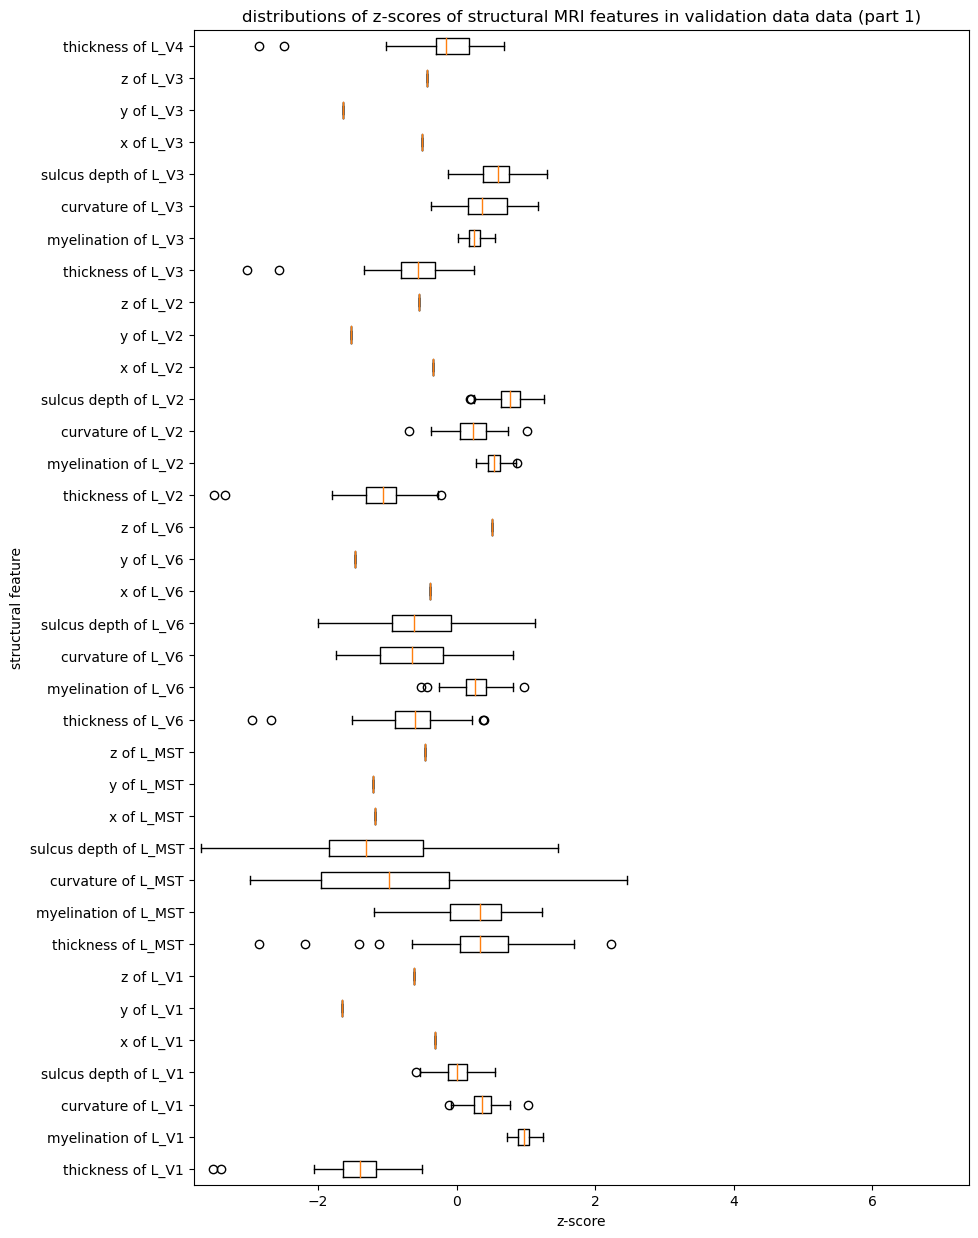

In [679]:
z_score_min = node_features_plus_sc_z.min().item()
z_score_max = node_features_plus_sc_z.max().item()
z_score_margin = 0.1
z_score_lim = [z_score_min-z_score_margin, z_score_max+z_score_margin]
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 15))
feature_increment = 36
feature_min = 0
feature_max = feature_min + feature_increment
axs.boxplot( node_features_plus_sc_z[:,feature_min:feature_max].detach().cpu().numpy(), vert=False )
axs.set_xlim(z_score_lim)
axs.set_yticklabels(feature_name_list[feature_min:feature_max])
axs.set_ylabel('structural feature')
axs.set_xlabel('z-score')
axs.set_title(f'distributions of z-scores of structural MRI features in validation data data (part 1)')

The magnitudes of the eigenvalues of the combined FIM range from 1.14e-10 to 598.


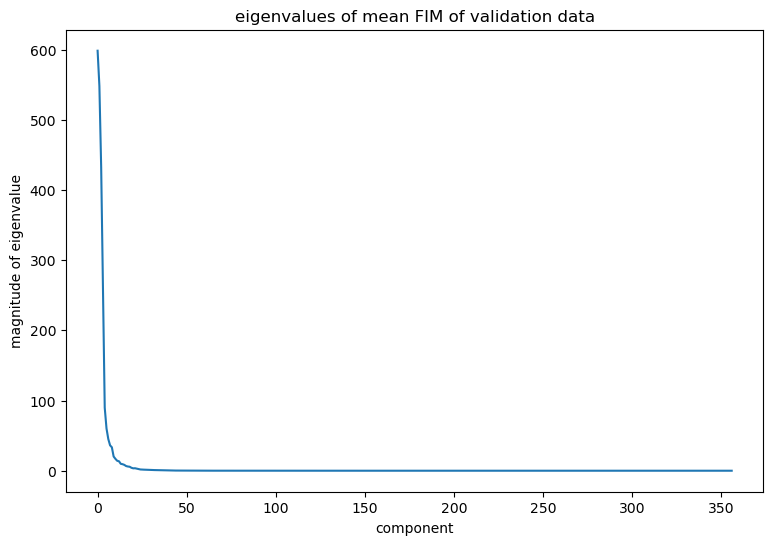

In [680]:
L_fim_abs = L_fim.abs()
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.plot( L_fim_abs.detach().cpu().numpy() )
axs.set_xlabel('component')
axs.set_ylabel('magnitude of eigenvalue')
axs.set_title(f'eigenvalues of mean FIM of validation data')
print( f'The magnitudes of the eigenvalues of the combined FIM range from {L_fim_abs.min():.3g} to {L_fim_abs.max():.3g}.' )

Text(0.5, 1.0, 'cumulative fraction of magnitudes eigenvalues of mean FIM of validation data')

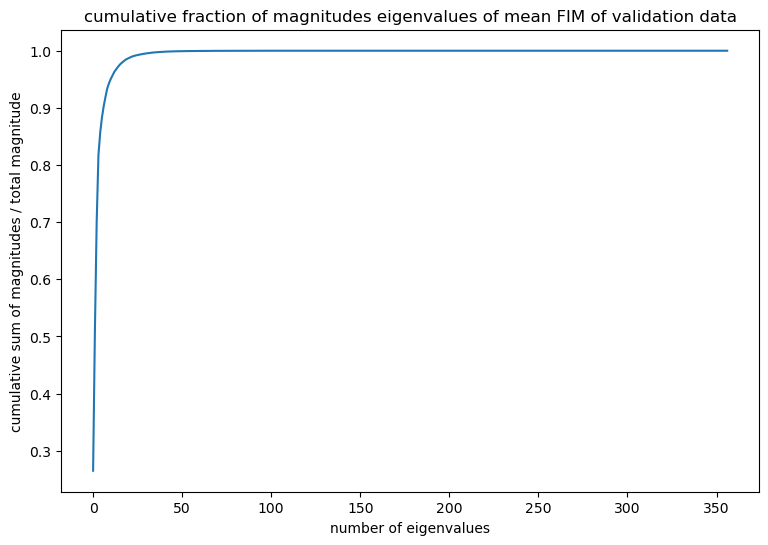

In [681]:
cum_L_fim_abs_exp = torch.cumsum( L_fim_abs/L_fim_abs.sum(), dim=0 )
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.plot( cum_L_fim_abs_exp.detach().cpu().numpy() )
axs.set_xlabel('number of eigenvalues')
axs.set_ylabel('cumulative sum of magnitudes / total magnitude')
axs.set_title(f'cumulative fraction of magnitudes eigenvalues of mean FIM of validation data')
# print( f'The eigenvalues of the principal components range from {S.min():.3g} to {S.max():.3g}.' )

In [682]:
threshold = 0.95
print( f'number of eigenvalues needed to pass {100*threshold}%: {torch.count_nonzero(cum_L_fim_abs_exp < threshold).item()+1}' )

number of eigenvalues needed to pass 95.0%: 11


In [683]:
L_fim_gini = torch.mean( (L_fim_abs[:,None] - L_fim_abs[None,:]).abs() )/( 2.0 * torch.mean(L_fim_abs) )
print(f'Gini coefficient of the eigenvalue magnitudes: {L_fim_gini:.3g}')

Gini coefficient of the eigenvalue magnitudes: 0.982


In [684]:
features_times_V_fim = torch.matmul(node_features_plus_sc_z, V_fim.real)

Text(0.5, 1.0, 'projections of structural feature variation onto FIM eigenvectors for mean FRIM from validation data')

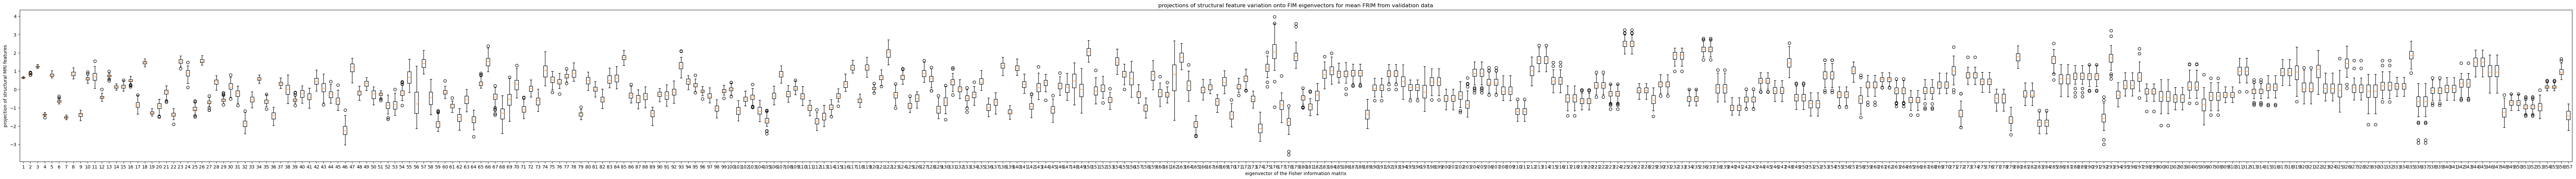

In [685]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(100, 6))
axs.boxplot( features_times_V_fim.detach().cpu().numpy() )
# axs.set_xticklabels(param_names, rotation=45, ha='right')
axs.set_xlabel('eigenvector of the Fisher information matrix')
axs.set_ylabel('projection of structural MRI features')
axs.set_title(f'projections of structural feature variation onto FIM eigenvectors for mean FRIM from validation data')

Text(0.5, 1.0, 'parameter variance along eigenvector vs eigenvalue')

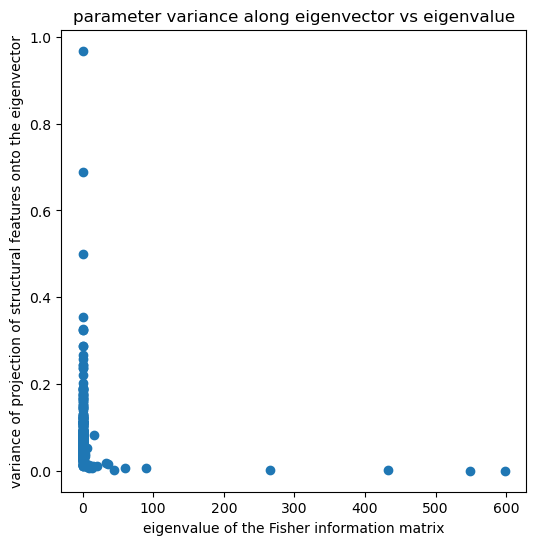

In [686]:
features_times_V_fim_variance = features_times_V_fim.var(dim=0)
# print( features_times_V_fim.size() )
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
axs.scatter( L_fim.real.detach().cpu().numpy(), features_times_V_fim_variance.detach().cpu().numpy() )
# axs.set_xticklabels(param_names, rotation=45, ha='right')
axs.set_xlabel('eigenvalue of the Fisher information matrix')
axs.set_ylabel('variance of projection of structural features onto the eigenvector')
axs.set_title(f'parameter variance along eigenvector vs eigenvalue')

Text(0.5, 1.0, 'parameter variance along eigenvector vs eigenvalue')

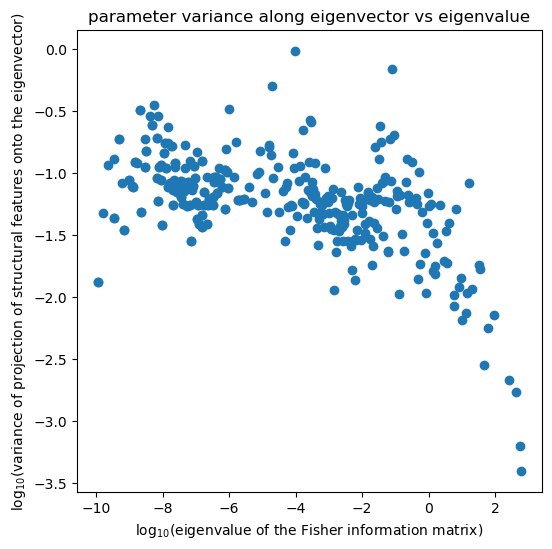

In [687]:
features_times_V_fim_variance = features_times_V_fim.var(dim=0)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
axs.scatter( torch.log10(L_fim).real.detach().cpu().numpy(), torch.log10(features_times_V_fim_variance).detach().cpu().numpy() )
# axs.set_xticklabels(param_names, rotation=45, ha='right')
axs.set_xlabel('log$_{10}$(eigenvalue of the Fisher information matrix)')
axs.set_ylabel('log$_{10}$(variance of projection of structural features onto the eigenvector)')
axs.set_title(f'parameter variance along eigenvector vs eigenvalue')

Text(0.5, 1.0, 'leading eigenvector components of selected features')

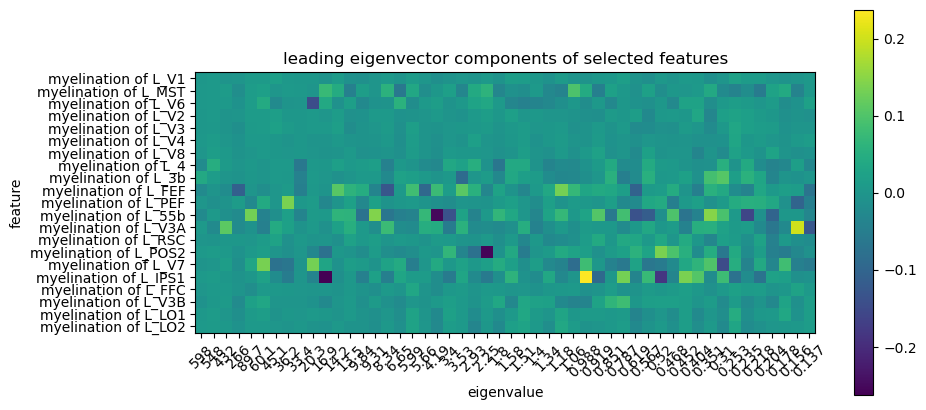

In [688]:
# fim_region_feature_corr_table = pandas.DataFrame( V_fim_np, columns=feature_names_with_sc_sum, index=feature_names_with_sc_sum )
# print(fim_region_feature_corr_table)
# fim_region_feature_corr_table.to_csv( os.path.join(stats_dir, 'region_feature_fim_table_correlation_21_nodes_validation_mean.csv') )

eig_selection = torch.arange(start=0, end=50, step=1, device=device)
selected_eigs = [f'{eig_val:.3g}' for eig_val in L_fim[eig_selection].real]
num_eigs = len(selected_eigs)
eig_ticks = range(num_eigs)

features_per_node = 7
feature_selection = torch.arange(start=1, end=features_per_node*num_nodes, step=features_per_node, device=device)
selected_features = [ feature_name_list[i] for i in feature_selection ]
num_features = len(selected_features)
feature_ticks = range(num_features)

selected_V_fim = V_fim[ feature_selection[:,None].repeat( (1,num_eigs) ), eig_selection[None,:].repeat(num_features,1) ].real.cpu().numpy()

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
pos = axs.imshow(selected_V_fim)
axs.set_xticks(eig_ticks, labels=selected_eigs, rotation=45, fontsize=10)
axs.set_yticks(feature_ticks, labels=selected_features, rotation=0, fontsize=10)
fig.colorbar(pos, ax=axs, shrink=0.5)
axs.set_xlabel('eigenvalue')
axs.set_ylabel('feature')
axs.set_title(f'leading eigenvector components of selected features')

In [689]:
task_score_table = pandas.read_csv( os.path.join(data_dir, 'HCPS1200_behavioral_gfactor_modeling.csv') )
print( task_score_table.head() )

   Subject Gender    Age  PMAT24_A_CR  VSPLOT_TC  ListSort_Unadj  \
0   100004      M  22-25         19.0        9.0           96.99   
1   100206      M  26-30         20.0       12.0          112.89   
2   100307      F  26-30         17.0        9.0          108.06   
3   100408      M  31-35          7.0       17.0          108.06   
4   100610      M  26-30         23.0       18.0          117.39   

   PicSeq_Unadj  IWRD_TOT  PicVocab_Unadj  ReadEng_Unadj  CardSort_Unadj  \
0        118.70      37.0        111.1118       109.9589          103.17   
1        125.07      34.0        119.8914       113.5460          119.14   
2        110.61      35.0        107.2000       111.0700          123.75   
3        125.71      37.0        134.2400       131.8100          111.14   
4        109.04      38.0        140.8151       141.3166          129.84   

   Flanker_Unadj  ProcSpeed_Unadj  Language_Task_Story_Acc  \
0         121.97            92.72                      NaN   
1         

In [690]:
structural_feature_table = pandas.DataFrame( node_features_plus_sc_z.detach().cpu().numpy(), columns=feature_name_list )
print( structural_feature_table.head() )

   thickness of L_V1  myelination of L_V1  curvature of L_V1  \
0          -1.125051             1.066063           0.416306   
1          -1.273762             1.017275           0.326916   
2          -1.636279             1.046176           0.337974   
3          -1.164742             1.055143           0.185218   
4          -1.663556             0.891664           0.529042   

   sulcus depth of L_V1  x of L_V1  y of L_V1  z of L_V1  thickness of L_MST  \
0             -0.287766  -0.312311  -1.645825  -0.611714            0.435841   
1             -0.160259  -0.312311  -1.645825  -0.611714            0.833733   
2              0.050642  -0.312311  -1.645825  -0.611714            1.527106   
3             -0.123906  -0.312311  -1.645825  -0.611714           -0.021802   
4              0.136309  -0.312311  -1.645825  -0.611714            0.398501   

   myelination of L_MST  curvature of L_MST  ...  SC from L_IPS1 to L_FFC  \
0              1.232093           -2.587243  ...         

In [691]:
eig_column_names = [ f'eig{i}' for i in range( features_times_V_fim.size(dim=1) ) ]
eigenvector_projection_table = pandas.DataFrame( features_times_V_fim.detach().cpu().numpy(), columns=eig_column_names )
print( eigenvector_projection_table.head() )

       eig0      eig1      eig2      eig3      eig4      eig5      eig6  \
0  0.666810  0.847907  1.270689 -1.423067  0.681897 -0.711431 -1.487392   
1  0.639500  0.824127  1.316188 -1.384776  0.778236 -0.566530 -1.539483   
2  0.631430  0.859993  1.208648 -1.378502  0.708415 -0.728011 -1.468031   
3  0.635487  0.840967  1.195412 -1.296916  0.864915 -0.470004 -1.554911   
4  0.643893  0.821811  1.257137 -1.385942  0.772271 -0.695655 -1.526841   

       eig7      eig8      eig9  ...    eig347    eig348    eig349    eig350  \
0  0.830291 -1.288387  0.558028  ... -0.623096 -0.871794 -0.871794 -1.212720   
1  0.881644 -1.361177  0.647707  ... -1.718539 -0.925157 -0.925157 -1.130773   
2  0.923169 -1.256312  0.543873  ... -1.100513 -0.684955 -0.684955 -1.018567   
3  1.026963 -1.312707  0.776678  ... -1.104733 -0.928426 -0.928426 -1.014532   
4  0.821247 -1.426008  0.483058  ... -1.195525 -0.256212 -0.256212 -0.526518   

     eig351    eig352    eig353    eig354    eig355    eig356  
0 -1

In [692]:
subject_id_table = pandas.DataFrame(validation_subject_list, columns=['Subject'])
print( subject_id_table.head() )

   Subject
0   826454
1   145834
2   101309
3   889579
4   530635


In [693]:
print( subject_id_table.shape )
print( structural_feature_table.shape )
print( eigenvector_projection_table.shape )
struct_and_eigen_table = pandas.concat([subject_id_table, structural_feature_table, eigenvector_projection_table], axis=1)
print( struct_and_eigen_table.head() )

(84, 1)
(84, 357)
(84, 357)
   Subject  thickness of L_V1  myelination of L_V1  curvature of L_V1  \
0   826454          -1.125051             1.066063           0.416306   
1   145834          -1.273762             1.017275           0.326916   
2   101309          -1.636279             1.046176           0.337974   
3   889579          -1.164742             1.055143           0.185218   
4   530635          -1.663556             0.891664           0.529042   

   sulcus depth of L_V1  x of L_V1  y of L_V1  z of L_V1  thickness of L_MST  \
0             -0.287766  -0.312311  -1.645825  -0.611714            0.435841   
1             -0.160259  -0.312311  -1.645825  -0.611714            0.833733   
2              0.050642  -0.312311  -1.645825  -0.611714            1.527106   
3             -0.123906  -0.312311  -1.645825  -0.611714           -0.021802   
4              0.136309  -0.312311  -1.645825  -0.611714            0.398501   

   myelination of L_MST  ...    eig347    eig348    

In [694]:
struct_and_eigen_and_score_table = pandas.merge(struct_and_eigen_table, task_score_table, on='Subject', how='inner')
print( struct_and_eigen_and_score_table.head() )
print( struct_and_eigen_and_score_table.shape )

   Subject  thickness of L_V1  myelination of L_V1  curvature of L_V1  \
0   826454          -1.125051             1.066063           0.416306   
1   145834          -1.273762             1.017275           0.326916   
2   101309          -1.636279             1.046176           0.337974   
3   889579          -1.164742             1.055143           0.185218   
4   530635          -1.663556             0.891664           0.529042   

   sulcus depth of L_V1  x of L_V1  y of L_V1  z of L_V1  thickness of L_MST  \
0             -0.287766  -0.312311  -1.645825  -0.611714            0.435841   
1             -0.160259  -0.312311  -1.645825  -0.611714            0.833733   
2              0.050642  -0.312311  -1.645825  -0.611714            1.527106   
3             -0.123906  -0.312311  -1.645825  -0.611714           -0.021802   
4              0.136309  -0.312311  -1.645825  -0.611714            0.398501   

   myelination of L_MST  ...  CardSort_Unadj  Flanker_Unadj  ProcSpeed_Unadj  \


In [695]:
task_score_names = task_score_table.columns[3:]
# eig_task_correlations = struct_and_eigen_and_score_table[eig_column_names].corrwith(struct_and_eigen_and_score_table[task_score_names], axis=0, drop=True)
all_correlations = struct_and_eigen_and_score_table.corr(numeric_only=True)
eig_task_correlations = all_correlations.loc[eig_column_names, task_score_names]
print( eig_task_correlations.head() )
print( eig_task_correlations.shape )

      PMAT24_A_CR  VSPLOT_TC  ListSort_Unadj  PicSeq_Unadj  IWRD_TOT  \
eig0     0.146871   0.074577       -0.018887     -0.220765 -0.023425   
eig1    -0.077822  -0.096786        0.094771      0.030856  0.105719   
eig2     0.072123  -0.016540       -0.092331     -0.138609 -0.145397   
eig3     0.001137  -0.057752       -0.029899      0.108256 -0.023215   
eig4     0.118559   0.062806        0.036359     -0.034974 -0.007175   

      PicVocab_Unadj  ReadEng_Unadj  CardSort_Unadj  Flanker_Unadj  \
eig0        0.068067      -0.004906        0.227929       0.071107   
eig1       -0.144044      -0.140001       -0.109470      -0.088868   
eig2        0.010818      -0.018550        0.110092      -0.026679   
eig3        0.071726       0.180376        0.057915       0.056994   
eig4        0.010249       0.109015        0.032158       0.018169   

      ProcSpeed_Unadj  Language_Task_Story_Acc  Language_Task_Math_Acc  \
eig0         0.137908                 0.036070               -0.172658  

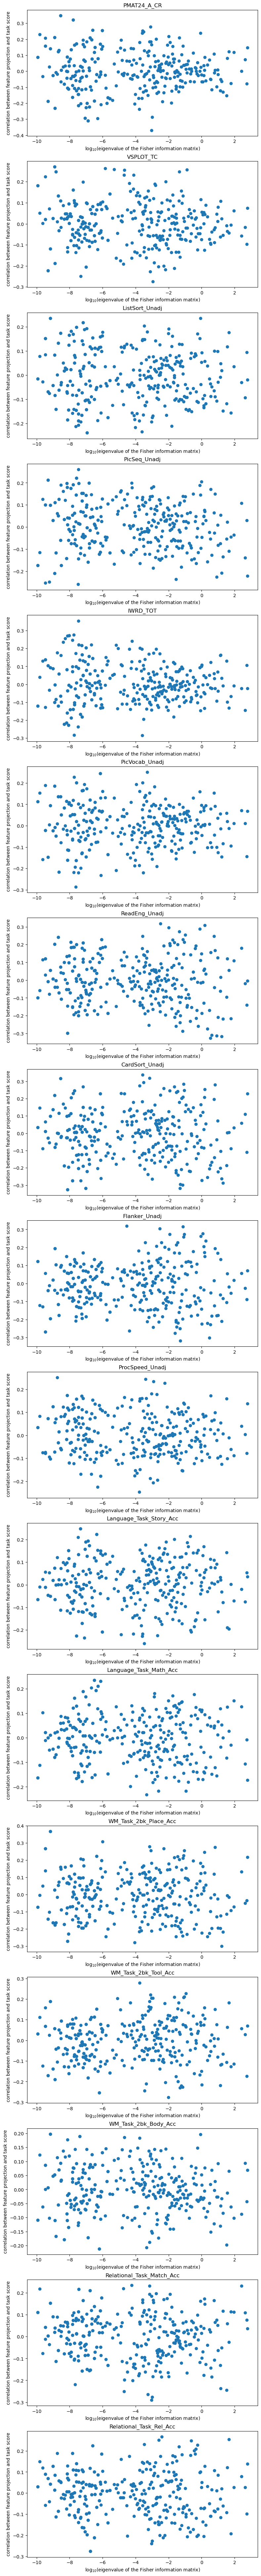

In [696]:
num_tasks = eig_task_correlations.shape[1]
fig, axs = plt.subplots(nrows=num_tasks, ncols=1, figsize=(9, 100))
for task in range(num_tasks):
    axs[task].scatter( torch.log10(L_fim).real.detach().cpu().numpy(), eig_task_correlations.to_numpy()[:,task] )#, label=eig_task_correlations.columns )
    # axs.set_xticklabels(param_names, rotation=45, ha='right')
    # plt.legend()
    axs[task].set_xlabel('log$_{10}$(eigenvalue of the Fisher information matrix)')
    axs[task].set_ylabel('correlation between feature projection and task score')
    axs[task].set_title(eig_task_correlations.columns[task])

Text(0.5, 1.0, 'PMAT24_A_CR')

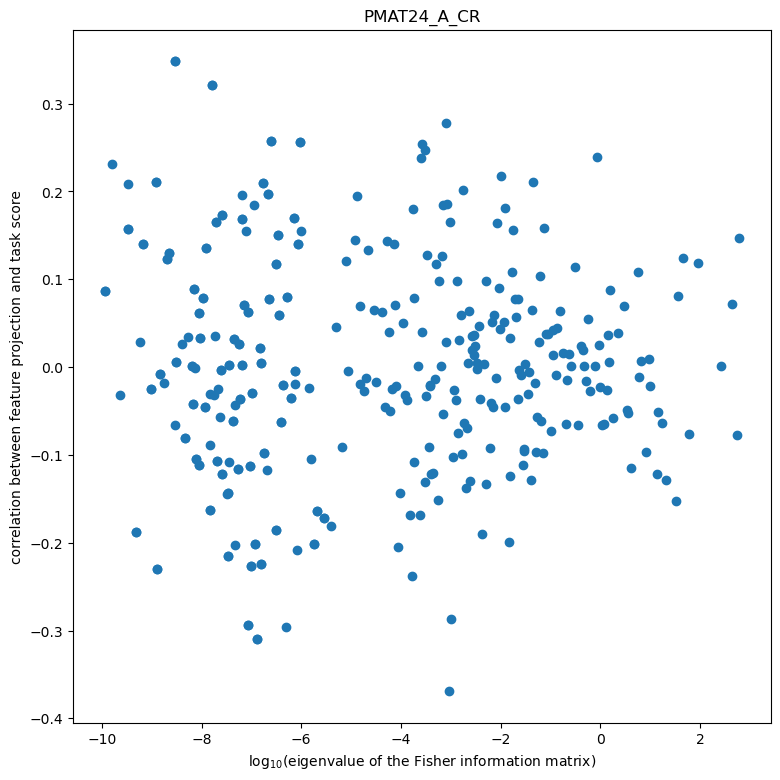

In [697]:
# Just plot one as an example.
num_tasks = eig_task_correlations.shape[1]
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 9))
task = 0
axs.scatter( torch.log10(L_fim).real.detach().cpu().numpy(), eig_task_correlations.to_numpy()[:,task] )#, label=eig_task_correlations.columns )
# axs.set_xticklabels(param_names, rotation=45, ha='right')
# plt.legend()
axs.set_xlabel('log$_{10}$(eigenvalue of the Fisher information matrix)')
axs.set_ylabel('correlation between feature projection and task score')
axs.set_title(eig_task_correlations.columns[task])

torch.Size([294, 294])


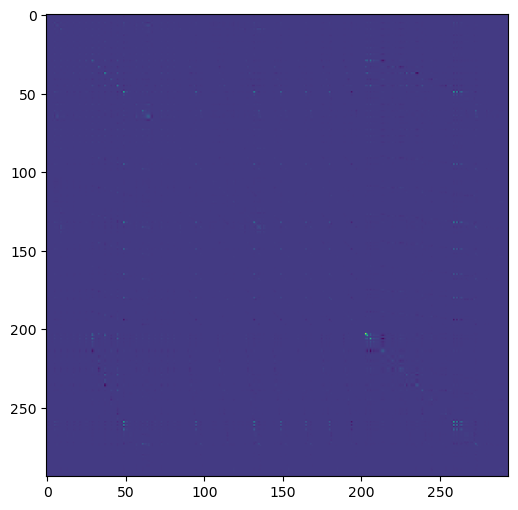

In [698]:
is_not_xyz = [ (not i_is_x) and (not i_is_y) and (not i_is_z) for i_is_x, i_is_y, i_is_z in zip(is_x, is_y, is_z)]
# print(is_not_xyz)
fim_struct2ising_noxyz = (fim_struct2ising[is_not_xyz,:])[:,is_not_xyz]
print( fim_struct2ising_noxyz.size() )
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.imshow( fim_struct2ising_noxyz.detach().cpu().numpy() )

In [699]:
L_fim_noxyz, V_fim_noxyz = torch.linalg.eig(fim_struct2ising_noxyz)
print( 'L_fim_noxyz size:', L_fim_noxyz.size() )
print( 'V_fim_noxyz size:', V_fim_noxyz.size() )

L_fim_noxyz size: torch.Size([294])
V_fim_noxyz size: torch.Size([294, 294])


The magnitudes of the eigenvalues of the combined FIM range from 3.43e-11 to 22.4.


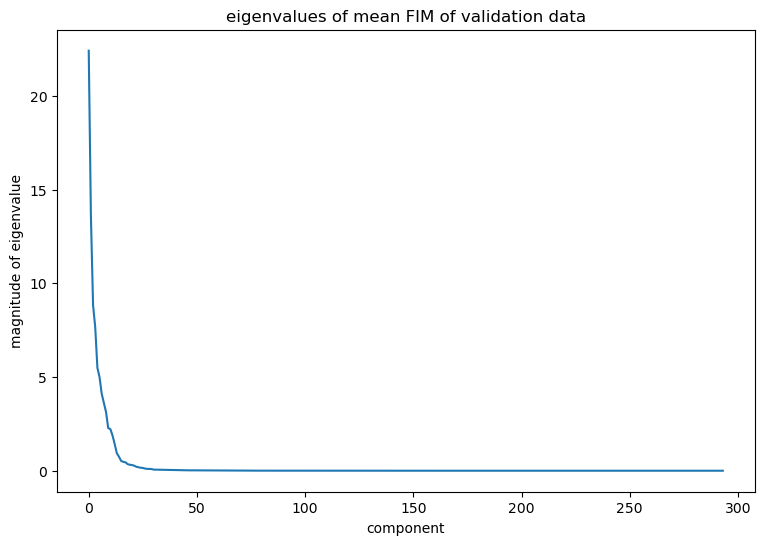

In [700]:
L_fim_abs_noxyz = L_fim_noxyz.abs()
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.plot( L_fim_abs_noxyz.detach().cpu().numpy() )
axs.set_xlabel('component')
axs.set_ylabel('magnitude of eigenvalue')
axs.set_title(f'eigenvalues of mean FIM of validation data')
print( f'The magnitudes of the eigenvalues of the combined FIM range from {L_fim_abs_noxyz.min():.3g} to {L_fim_abs_noxyz.max():.3g}.' )

number of eigenvalues needed to pass 95.0%: 16
Gini coefficient of the eigenvalue magnitudes: 0.966


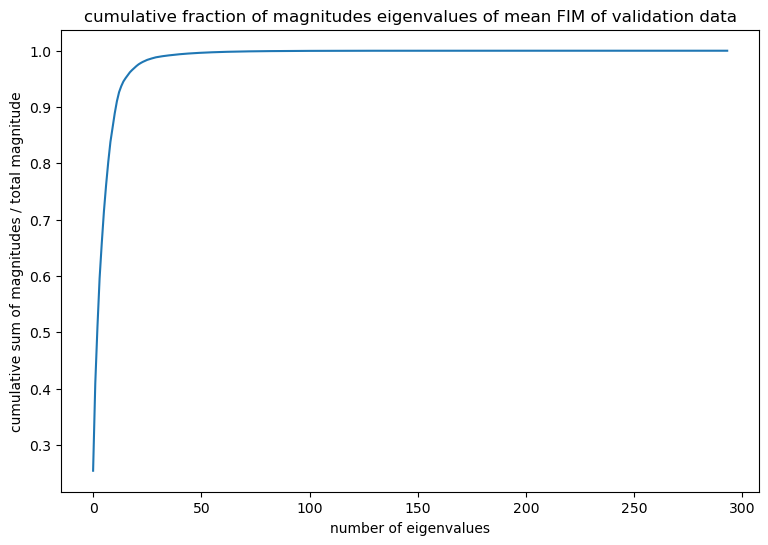

In [701]:
cum_L_fim_abs_exp_noxyz = torch.cumsum( L_fim_abs_noxyz/L_fim_abs_noxyz.sum(), dim=0 )
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.plot( cum_L_fim_abs_exp_noxyz.detach().cpu().numpy() )
axs.set_xlabel('number of eigenvalues')
axs.set_ylabel('cumulative sum of magnitudes / total magnitude')
axs.set_title(f'cumulative fraction of magnitudes eigenvalues of mean FIM of validation data')

threshold = 0.95
print( f'number of eigenvalues needed to pass {100*threshold}%: {torch.count_nonzero(cum_L_fim_abs_exp_noxyz < threshold).item()+1}' )

L_fim_gini_noxyz = torch.mean( (L_fim_abs_noxyz[:,None] - L_fim_abs_noxyz[None,:]).abs() )/( 2.0 * torch.mean(L_fim_abs_noxyz) )
print(f'Gini coefficient of the eigenvalue magnitudes: {L_fim_gini_noxyz:.3g}')

In [702]:
node_features_plus_sc_z_noxyz = node_features_plus_sc_z[:,is_not_xyz]
print( node_features_plus_sc_z_noxyz.size() )

torch.Size([84, 294])


In [703]:
features_times_V_fim_noxyz = torch.matmul(node_features_plus_sc_z_noxyz, V_fim_noxyz.real)

In [704]:
feature_name_list_noxyz = [name for name, xyz_notness in zip(feature_name_list, is_not_xyz) if xyz_notness]
print( len(feature_name_list_noxyz) )

294


Text(0.5, 1.0, 'distributions of z-scores of structural MRI features in validation data')

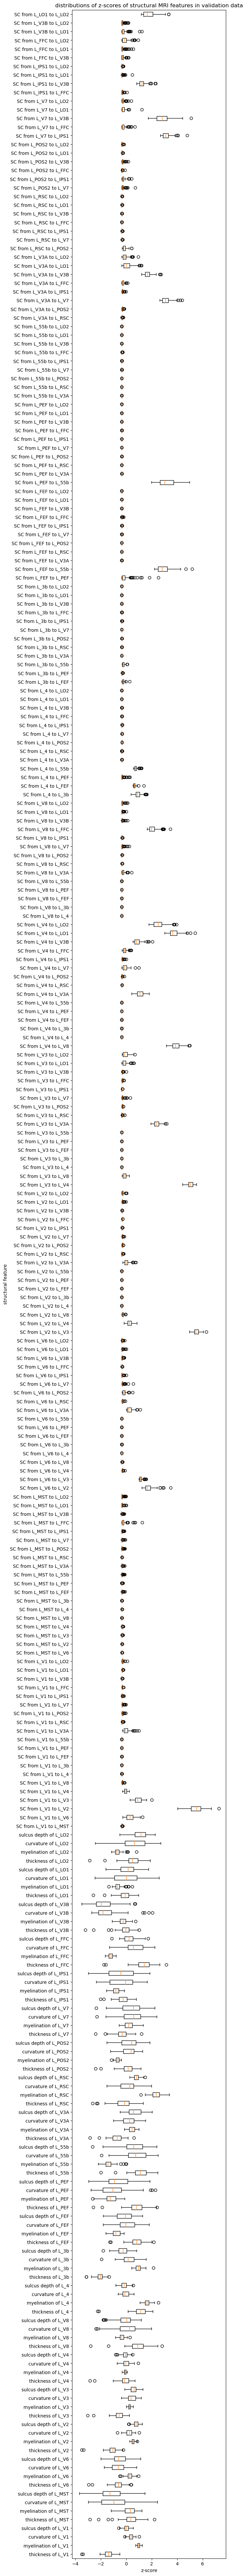

In [705]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 100))
axs.boxplot( node_features_plus_sc_z_noxyz.detach().cpu().numpy(), vert=False )
axs.set_yticklabels(feature_name_list_noxyz)
axs.set_ylabel('structural feature')
axs.set_xlabel('z-score')
axs.set_title(f'distributions of z-scores of structural MRI features in validation data')

Text(0.5, 1.0, 'distributions of z-scores of structural MRI features in validation data (part 1)')

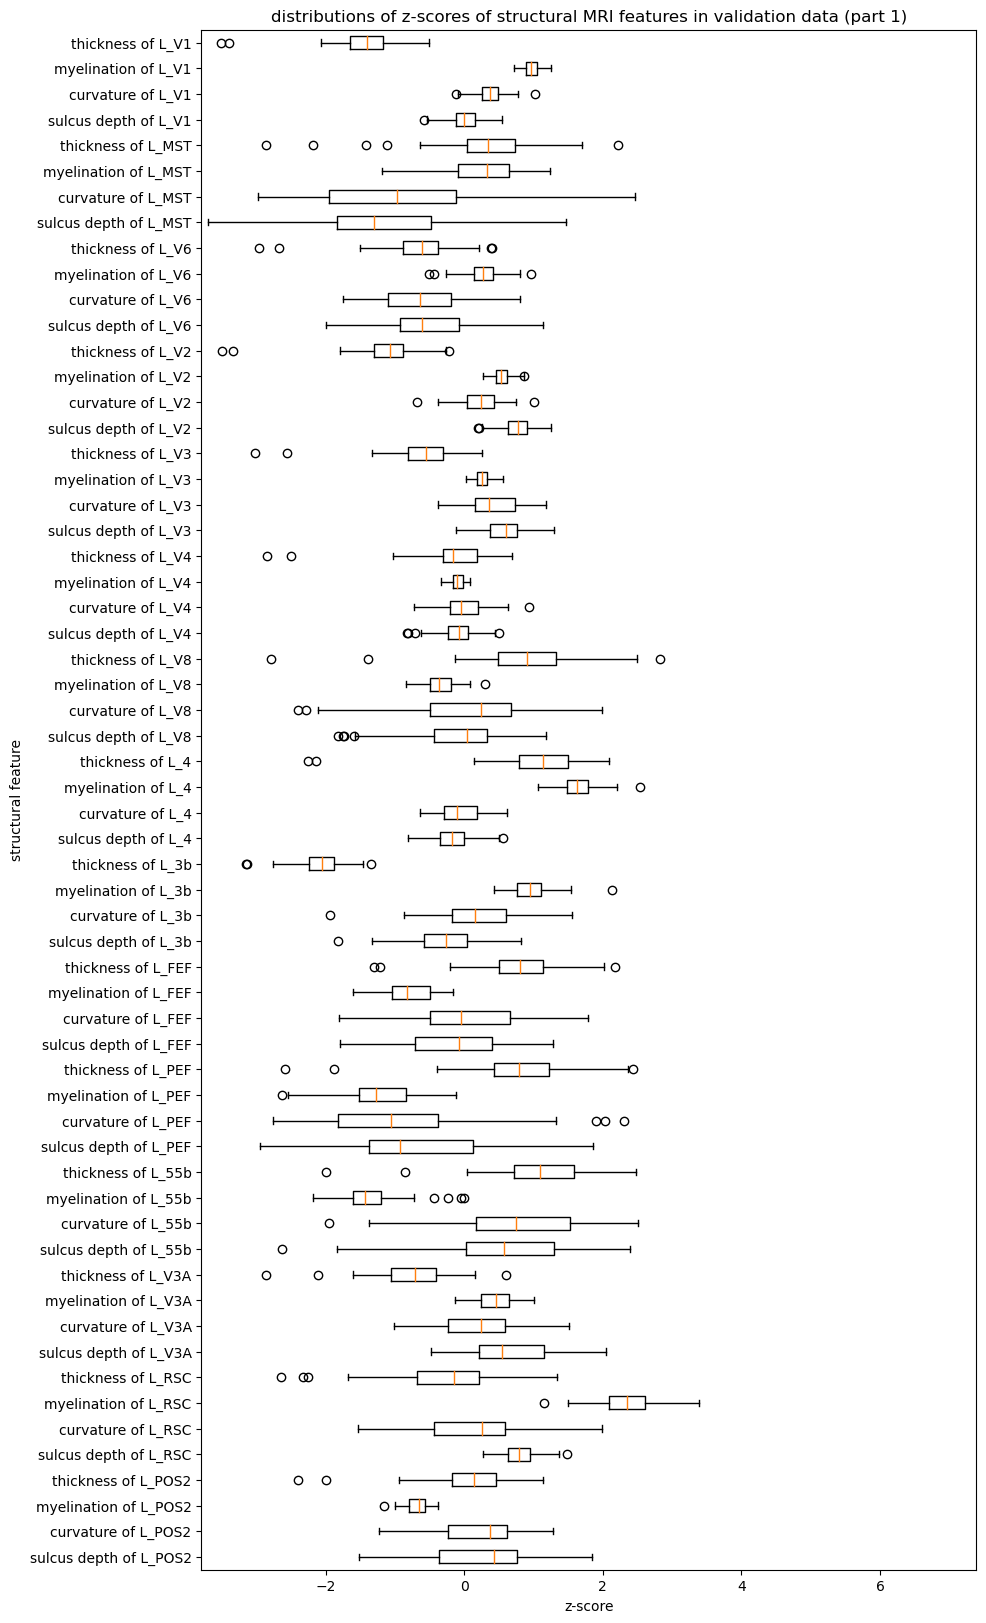

In [706]:
z_score_min = node_features_plus_sc_z.min().item()
z_score_max = node_features_plus_sc_z.max().item()
z_score_margin = 0.1
z_score_lim = [z_score_min-z_score_margin, z_score_max+z_score_margin]
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 20))
num_features = node_features_plus_sc_z_noxyz.size(dim=1)
feature_increment = 60
feature_min = 0
feature_max = feature_min + feature_increment
part_num = 1
axs.boxplot( torch.flip(node_features_plus_sc_z_noxyz[:,feature_min:feature_max],dims=[1]).detach().cpu().numpy(), vert=False )
axs.set_xlim(z_score_lim)
axs.set_yticklabels( reversed(feature_name_list_noxyz[feature_min:feature_max]) )
axs.set_ylabel('structural feature')
axs.set_xlabel('z-score')
axs.set_title(f'distributions of z-scores of structural MRI features in validation data (part {part_num})')

Text(0.5, 1.0, 'distributions of z-scores of structural MRI features in validation data (part 2)')

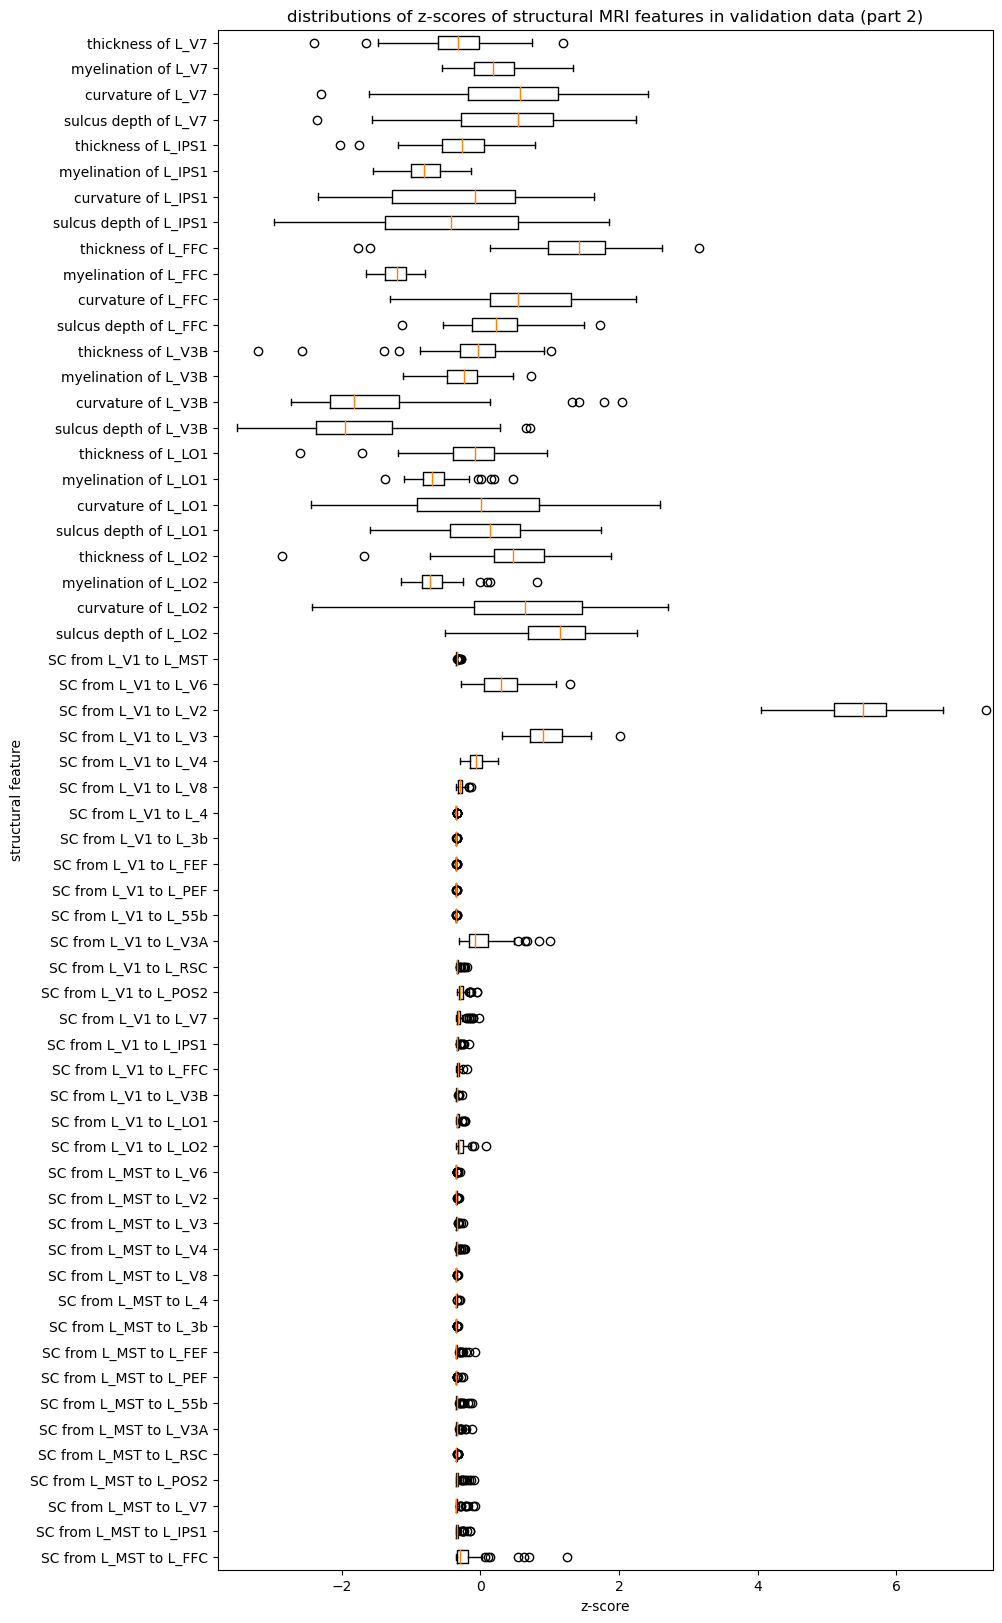

In [707]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 20))
feature_min = feature_max if feature_max != num_features else 0
feature_max = min(feature_min + feature_increment, num_features)
part_num = part_num + 1 if feature_min != 0 else 1
axs.boxplot( torch.flip(node_features_plus_sc_z_noxyz[:,feature_min:feature_max],dims=[1]).detach().cpu().numpy(), vert=False )
axs.set_xlim(z_score_lim)
axs.set_yticklabels( reversed(feature_name_list_noxyz[feature_min:feature_max]) )
axs.set_ylabel('structural feature')
axs.set_xlabel('z-score')
axs.set_title(f'distributions of z-scores of structural MRI features in validation data (part {part_num})')

Text(0.5, 1.0, 'projections of structural feature variation onto FIM eigenvectors for mean FRIM from validation data')

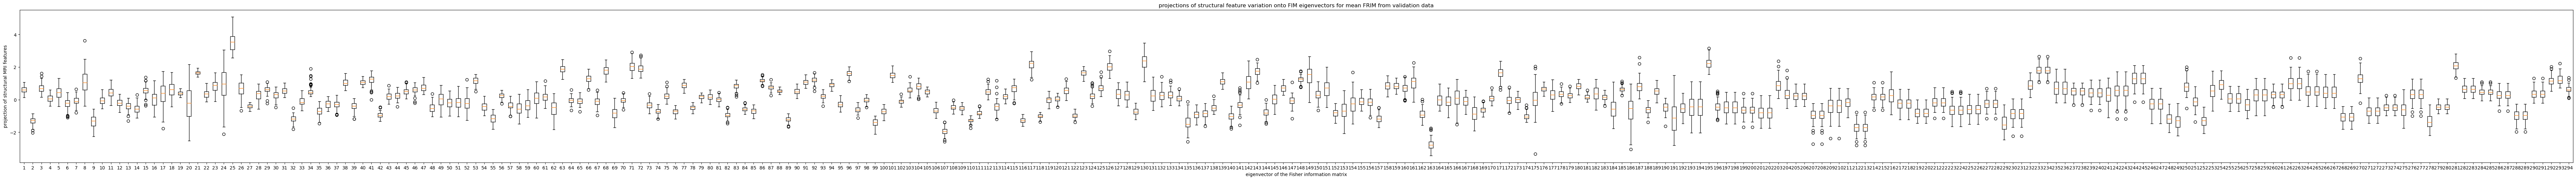

In [708]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(100, 6))
axs.boxplot( features_times_V_fim_noxyz.detach().cpu().numpy() )
axs.set_xlabel('eigenvector of the Fisher information matrix')
axs.set_ylabel('projection of structural MRI features')
axs.set_title(f'projections of structural feature variation onto FIM eigenvectors for mean FRIM from validation data')

Text(0.5, 1.0, 'distributions of projections of structural MRI features onto eigenvectors (part 1)')

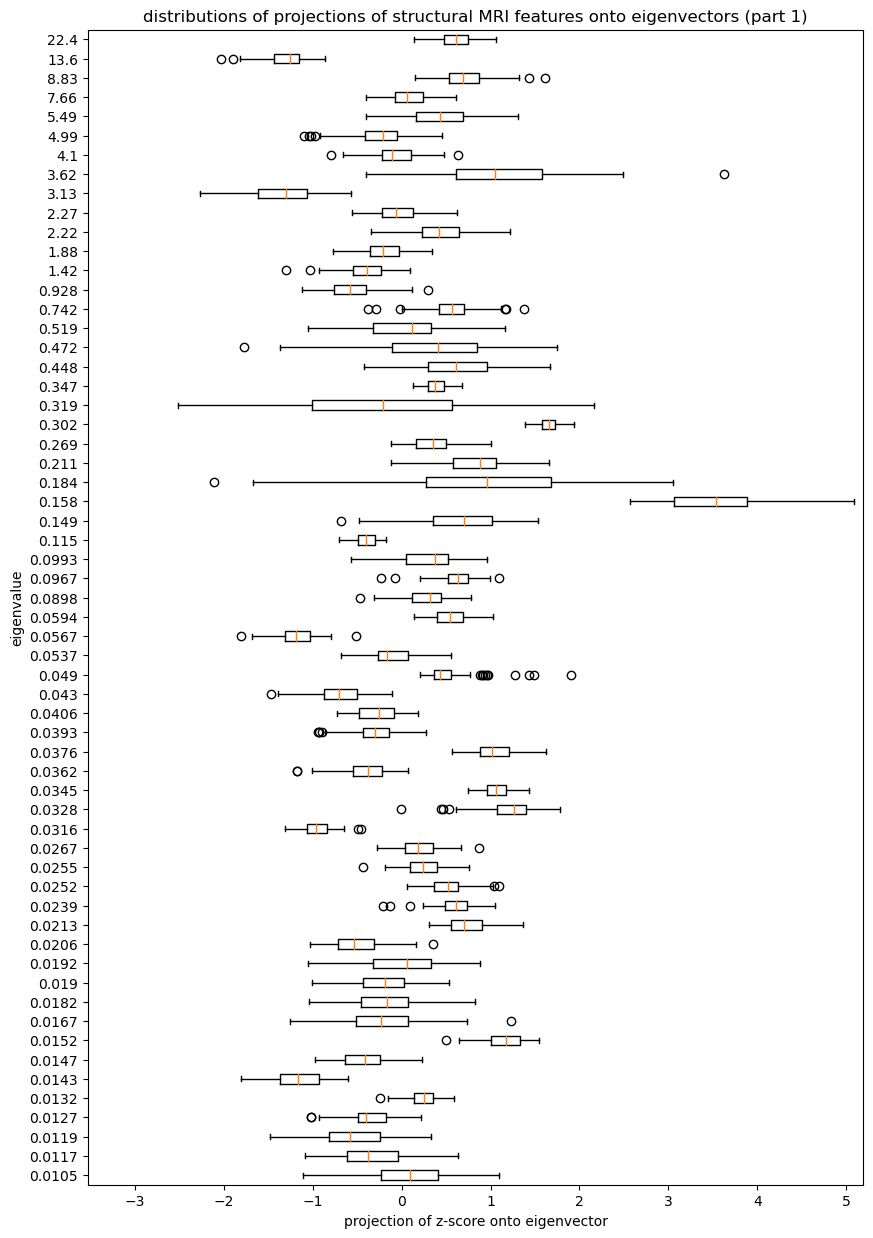

In [709]:
L_fim_sort_indices = torch.argsort(L_fim_noxyz.real, descending=True)
L_fim_sorted = L_fim_noxyz[L_fim_sort_indices]
features_times_V_fim_sorted = features_times_V_fim_noxyz[:,L_fim_sort_indices]
z_score_min = features_times_V_fim_sorted.min().item()
z_score_max = features_times_V_fim_sorted.max().item()
z_score_margin = 0.1
z_score_lim = [z_score_min-z_score_margin, z_score_max+z_score_margin]
num_features = features_times_V_fim_sorted.size(dim=1)
feature_increment = 60
feature_min = 0
feature_max = feature_min + feature_increment
part_num = 1
eig_strings = [f'{eigval:.3g}' for eigval in L_fim_sorted.real]
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 15))
axs.boxplot( torch.flip(features_times_V_fim_sorted[:,feature_min:feature_max],dims=[1]).detach().cpu().numpy(), vert=False )
axs.set_xlim(z_score_lim)
axs.set_yticklabels( reversed(eig_strings[feature_min:feature_max]) )
axs.set_ylabel('eigenvalue')
axs.set_xlabel('projection of z-score onto eigenvector')
axs.set_title(f'distributions of projections of structural MRI features onto eigenvectors (part {part_num})')

Text(0.5, 1.0, 'distributions of projections of structural MRI features onto eigenvectors (part 5)')

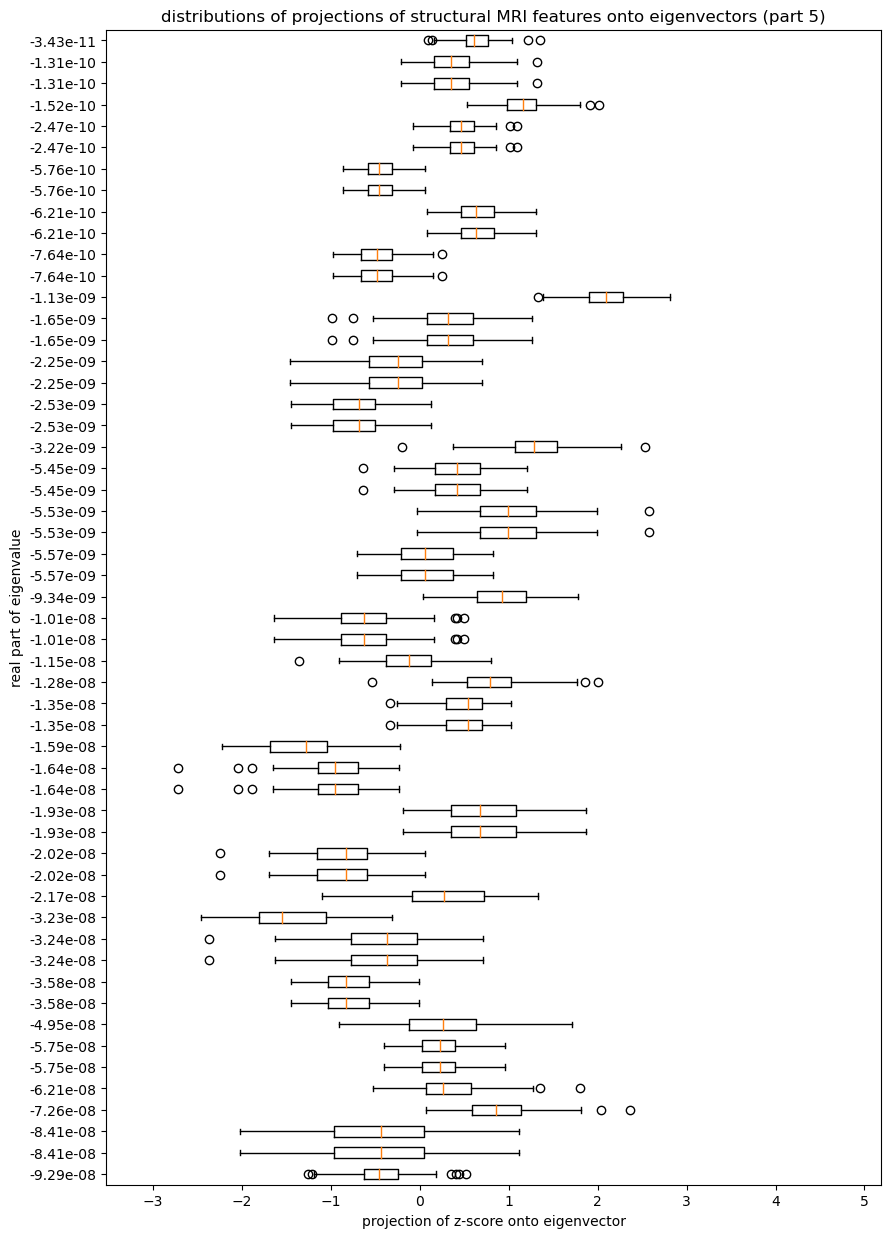

In [726]:
feature_min = feature_max if feature_max != num_features else 0
feature_max = min(feature_min + feature_increment, num_features)
part_num = part_num + 1 if feature_min != 0 else 1
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 15))
axs.boxplot( torch.flip(features_times_V_fim_sorted[:,feature_min:feature_max],dims=[1]).detach().cpu().numpy(), vert=False )
axs.set_xlim(z_score_lim)
axs.set_yticklabels( reversed(eig_strings[feature_min:feature_max]) )
axs.set_ylabel('real part of eigenvalue')
axs.set_xlabel('projection of z-score onto eigenvector')
axs.set_title(f'distributions of projections of structural MRI features onto eigenvectors (part {part_num})')

torch.Size([84, 294])


Text(0.5, 1.0, 'parameter variance along eigenvector vs eigenvalue')

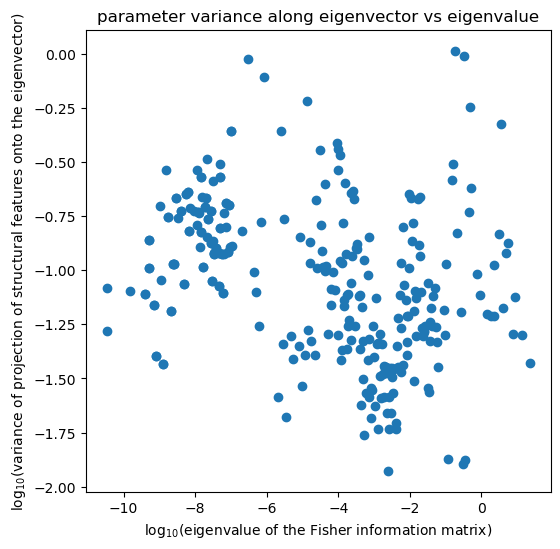

In [711]:
features_times_V_fim_variance_noxyz = features_times_V_fim_noxyz.var(dim=0)
print( features_times_V_fim_noxyz.size() )
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
log_real_L_fim = torch.log10( L_fim_noxyz.abs() )
log_features_times_V_fim_variance = torch.log10(features_times_V_fim_variance_noxyz)
axs.scatter( log_real_L_fim.detach().cpu().numpy(), log_features_times_V_fim_variance.detach().cpu().numpy() )
axs.set_xlabel('log$_{10}$(eigenvalue of the Fisher information matrix)')
axs.set_ylabel('log$_{10}$(variance of projection of structural features onto the eigenvector)')
axs.set_title(f'parameter variance along eigenvector vs eigenvalue')

In [712]:
log_log_L_V_corr = torch.corrcoef(  torch.stack( (log_real_L_fim, log_features_times_V_fim_variance) )  )
print(f'correlation between eigenvalues and variances of projected features: {log_log_L_V_corr[0,1]:.3g}')

correlation between eigenvalues and variances of projected features: -0.341


In [713]:
X_no1 = log_real_L_fim[:,None]
X = torch.cat(  ( X_no1, torch.ones_like(X_no1) ), dim=1  )
Y = log_features_times_V_fim_variance[:,None]
log_log_L_V_line = torch.linalg.lstsq(X, Y)
L_V_slope = log_log_L_V_line.solution[0].item()
L_V_intercept = log_log_L_V_line.solution[1].item()
L_V_rmse = log_log_L_V_line.residuals[0].sqrt().item()
Y_estimate = torch.matmul(X, log_log_L_V_line.solution)
L_V_rmse = torch.sqrt(  torch.mean( torch.square(Y_estimate - Y) )  )
L_V_R_sq = 1 - torch.sum( torch.square(Y_estimate - Y) )/torch.sum(  torch.square( Y - Y.mean() )  )
print(f'The regression line, log(var(projection onto V)) = {L_V_slope:.3g}log(L) + {L_V_intercept:.3g}, has R^2 {L_V_R_sq:.3g} and RMSE {L_V_rmse:.3g}.')

The regression line, log(var(projection onto V)) = -0.0424log(L) + -1.24, has R^2 0.117 and RMSE 0.336.


Text(0.5, 1.0, 'parameter variance along eigenvector vs eigenvalue')

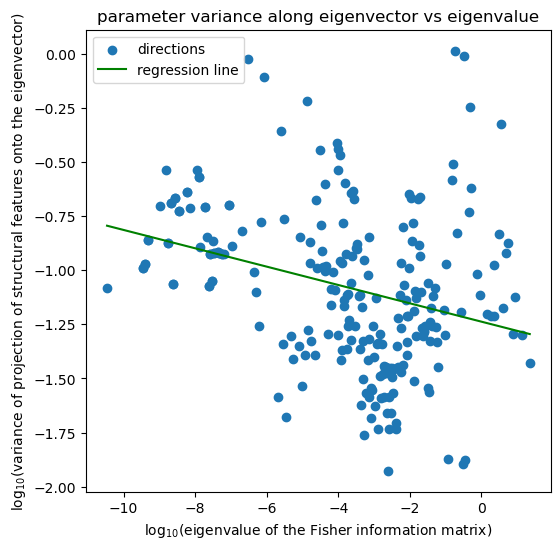

In [714]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
log_real_L_fim = torch.log10(L_fim_noxyz.real)
log_features_times_V_fim_variance = torch.log10(features_times_V_fim_variance_noxyz)
axs.scatter( log_real_L_fim.detach().cpu().numpy(), log_features_times_V_fim_variance.detach().cpu().numpy(), label='directions' )
axs.plot( X_no1.detach().cpu().numpy(), Y_estimate.detach().cpu().numpy(), color='green', label='regression line' )
axs.legend()
axs.set_xlabel('log$_{10}$(eigenvalue of the Fisher information matrix)')
axs.set_ylabel('log$_{10}$(variance of projection of structural features onto the eigenvector)')
axs.set_title(f'parameter variance along eigenvector vs eigenvalue')

In [715]:
structural_feature_table_noxyz = pandas.DataFrame( node_features_plus_sc_z_noxyz.detach().cpu().numpy(), columns=feature_name_list_noxyz )
print( structural_feature_table_noxyz.shape )
print( structural_feature_table_noxyz.head() )

(84, 294)
   thickness of L_V1  myelination of L_V1  curvature of L_V1  \
0          -1.125051             1.066063           0.416306   
1          -1.273762             1.017275           0.326916   
2          -1.636279             1.046176           0.337974   
3          -1.164742             1.055143           0.185218   
4          -1.663556             0.891664           0.529042   

   sulcus depth of L_V1  thickness of L_MST  myelination of L_MST  \
0             -0.287766            0.435841              1.232093   
1             -0.160259            0.833733              0.860804   
2              0.050642            1.527106              0.640139   
3             -0.123906           -0.021802             -0.689119   
4              0.136309            0.398501             -0.341759   

   curvature of L_MST  sulcus depth of L_MST  thickness of L_V6  \
0           -2.587243              -2.039948          -0.950711   
1           -0.658853              -1.237909          -0

In [716]:
eig_column_names_noxyz = [ f'eig{i}' for i in range( features_times_V_fim_noxyz.size(dim=1) ) ]
eigenvector_projection_table_noxyz = pandas.DataFrame( features_times_V_fim_noxyz.detach().cpu().numpy(), columns=eig_column_names_noxyz )
print( eigenvector_projection_table_noxyz.shape )
print( eigenvector_projection_table_noxyz.head() )

(84, 294)
       eig0      eig1      eig2      eig3      eig4      eig5      eig6  \
0  0.744766 -1.150608  0.624209 -0.096372  0.106162 -0.726314 -0.126635   
1  0.879110 -1.288797  0.674650  0.043052  0.472841  0.008731  0.260467   
2  0.447236 -1.163705  0.517677 -0.021928  0.420051 -0.913374  0.129010   
3  0.314571 -1.068177  0.857814  0.259261  0.875119 -0.095563  0.639571   
4  0.677312 -1.261936  0.843260 -0.070443  0.342732  0.041728 -0.239095   

       eig7      eig8      eig9  ...    eig284    eig285    eig286    eig287  \
0  1.625121 -0.868856  0.162702  ...  0.663912 -0.238390 -0.238390 -1.576866   
1  1.328286 -1.370608 -0.166826  ...  0.661823  0.451182  0.451182 -1.099118   
2  1.273386 -1.043132 -0.070684  ...  0.242376 -0.070728 -0.070728 -0.865718   
3  1.706762 -1.897319 -0.521606  ...  0.284160  0.573594  0.573594 -0.500337   
4 -0.016441 -1.301144 -0.082450  ...  0.605051  0.314663  0.314663 -0.806198   

     eig288    eig289    eig290    eig291    eig292    eig

In [717]:
struct_and_eigen_table_noxyz = pandas.concat([subject_id_table, structural_feature_table_noxyz, eigenvector_projection_table_noxyz], axis=1)
print( struct_and_eigen_table_noxyz.shape )
print( struct_and_eigen_table_noxyz.head() )

(84, 589)
   Subject  thickness of L_V1  myelination of L_V1  curvature of L_V1  \
0   826454          -1.125051             1.066063           0.416306   
1   145834          -1.273762             1.017275           0.326916   
2   101309          -1.636279             1.046176           0.337974   
3   889579          -1.164742             1.055143           0.185218   
4   530635          -1.663556             0.891664           0.529042   

   sulcus depth of L_V1  thickness of L_MST  myelination of L_MST  \
0             -0.287766            0.435841              1.232093   
1             -0.160259            0.833733              0.860804   
2              0.050642            1.527106              0.640139   
3             -0.123906           -0.021802             -0.689119   
4              0.136309            0.398501             -0.341759   

   curvature of L_MST  sulcus depth of L_MST  thickness of L_V6  ...  \
0           -2.587243              -2.039948          -0.950711 

In [718]:
struct_and_eigen_and_score_table_noxyz = pandas.merge(struct_and_eigen_table_noxyz, task_score_table, on='Subject', how='inner')
print( struct_and_eigen_and_score_table.shape )
print( struct_and_eigen_and_score_table.head() )

(84, 734)
   Subject  thickness of L_V1  myelination of L_V1  curvature of L_V1  \
0   826454          -1.125051             1.066063           0.416306   
1   145834          -1.273762             1.017275           0.326916   
2   101309          -1.636279             1.046176           0.337974   
3   889579          -1.164742             1.055143           0.185218   
4   530635          -1.663556             0.891664           0.529042   

   sulcus depth of L_V1  x of L_V1  y of L_V1  z of L_V1  thickness of L_MST  \
0             -0.287766  -0.312311  -1.645825  -0.611714            0.435841   
1             -0.160259  -0.312311  -1.645825  -0.611714            0.833733   
2              0.050642  -0.312311  -1.645825  -0.611714            1.527106   
3             -0.123906  -0.312311  -1.645825  -0.611714           -0.021802   
4              0.136309  -0.312311  -1.645825  -0.611714            0.398501   

   myelination of L_MST  ...  CardSort_Unadj  Flanker_Unadj  ProcSpeed

In [719]:
all_correlations_noxyz = struct_and_eigen_and_score_table_noxyz.corr(numeric_only=True)
eig_task_correlations_noxyz = all_correlations_noxyz.loc[eig_column_names_noxyz, task_score_names]
print( eig_task_correlations_noxyz.shape )
print( eig_task_correlations_noxyz.head() )

(294, 17)
      PMAT24_A_CR  VSPLOT_TC  ListSort_Unadj  PicSeq_Unadj  IWRD_TOT  \
eig0     0.086319   0.005198       -0.078790     -0.150244 -0.146238   
eig1    -0.073023   0.036217       -0.121282     -0.054326  0.043499   
eig2     0.162029   0.014273        0.062519     -0.002543 -0.183733   
eig3    -0.027949  -0.106997       -0.063439      0.052398  0.013359   
eig4     0.067320   0.019478        0.087082     -0.005982 -0.029644   

      PicVocab_Unadj  ReadEng_Unadj  CardSort_Unadj  Flanker_Unadj  \
eig0        0.041882       0.010995        0.126006      -0.009090   
eig1        0.103426      -0.014770       -0.027827      -0.015091   
eig2       -0.001272       0.110483        0.245069       0.110967   
eig3        0.024260       0.065134        0.073918      -0.018040   
eig4        0.023854       0.139228       -0.017616       0.023765   

      ProcSpeed_Unadj  Language_Task_Story_Acc  Language_Task_Math_Acc  \
eig0         0.035657                -0.080076               -

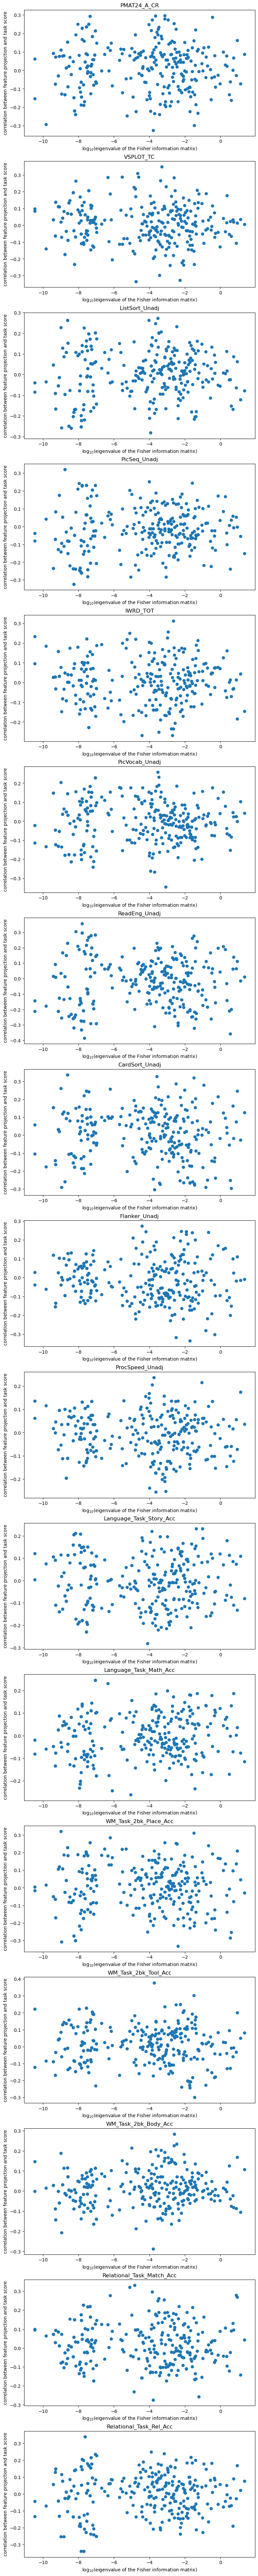

In [720]:
num_tasks = eig_task_correlations_noxyz.shape[1]
fig, axs = plt.subplots(nrows=num_tasks, ncols=1, figsize=(9, 100))
for task in range(num_tasks):
    axs[task].scatter( torch.log10(L_fim_noxyz).real.detach().cpu().numpy(), eig_task_correlations_noxyz.to_numpy()[:,task] )
    axs[task].set_xlabel('log$_{10}$(eigenvalue of the Fisher information matrix)')
    axs[task].set_ylabel('correlation between feature projection and task score')
    axs[task].set_title(eig_task_correlations_noxyz.columns[task])

Text(0.5, 1.0, 'PMAT24_A_CR')

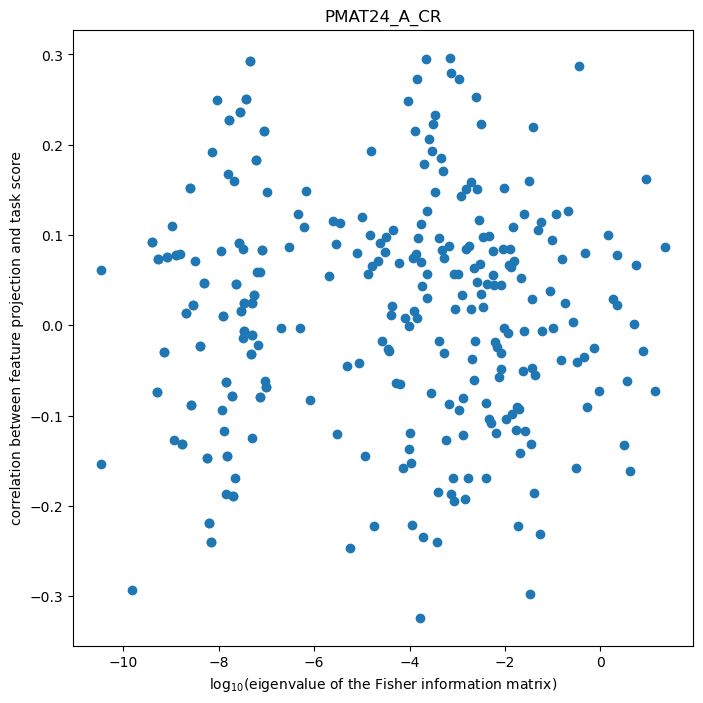

In [721]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
task = 0
axs.scatter( torch.log10(L_fim_noxyz).real.detach().cpu().numpy(), eig_task_correlations_noxyz.to_numpy()[:,task] )
axs.set_xlabel('log$_{10}$(eigenvalue of the Fisher information matrix)')
axs.set_ylabel('correlation between feature projection and task score')
axs.set_title(eig_task_correlations_noxyz.columns[task])

In [722]:
print(f'task-projection correlations range from {eig_task_correlations_noxyz.to_numpy().min():.3g} to {eig_task_correlations_noxyz.to_numpy().max():.3g}.')

task-projection correlations range from -0.385 to 0.378.


In [20]:
# total_num_nodes = 360
# total_num_params = total_num_nodes + ( total_num_nodes * (total_num_nodes-1) )//2
# print(total_num_params)
print( (231/90)*60580.411/3600 )

43.19158932407407
